In [1]:
import torch
import matplotlib.pyplot as plt

def rosenbrock(x, y, a=1, b=100):
    """Compute the Rosenbrock function for given x and y."""
    return (a - x) ** 2 + b * (y - x ** 2) ** 2

In [ ]:
# Contains a full implementation of the dynamic algorithm and the M-FAC optimizer


import torch
import torch.nn as nn


# Disable tensor cores as they can mess with precision
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False


# Use custom CUDA implementation for computing $B$ / `coef` if installed 
USE_CUDA = True 
try:
    import hinv_cuda
except Exception as e:
    USE_CUDA = False


# Full implementation of the dynamic algorithm with support for splitting gradients across GPUs
class HInvFastUpMulti:

    # `dev` is the device where all the coefficient calculation happens
    # `grads` ... initial $m \times d$ gradient matrix $G$; assumed to be on CPU (can be deleted afterwards)
    # `dev` ... device where coefficient calculation happens
    # `gpus` ... list of GPUs across which to split stored gradients 
    # `damp` ... dampening constant $\lambda$
    def __init__(self, grads, dev, gpus, damp=1e-5):
        self.m, self.d = grads.shape
        self.dev = dev 
        self.gpus = gpus
        self.dtype = grads.dtype
        self.lambd = 1. / damp

        if USE_CUDA and self.m % 32 != 0 or self.m > 1024:
            raise ValueError('CUDA implementation currently on supports $m$ < 1024 and divisible by 32.')

        self.dper = self.d // len(gpus) + 1 
        self.grads = [] # matrix $G$ in the paper
        for i in range(len(gpus)):
            start, end = i * self.dper, (i + 1) * self.dper
            self.grads.append(grads[:, start:end].to(gpus[i]))
        self.dots = torch.zeros((self.m, self.m), device=self.dev, dtype=self.dtype) # matrix $GG^T$
        for i in range(len(gpus)):
            self.dots += self.grads[i].matmul(self.grads[i].t()).to(self.dev)

        self.last = 0 # ringbuffer index
        self.giHig = self.lambd * self.dots # matrix $D$
        self.denom = torch.zeros(self.m, device=self.dev, dtype=self.dtype) # $D_ii + m$ 
        self.coef = self.lambd * torch.eye(self.m, device=self.dev, dtype=self.dtype) # matrix $B$
        self.setup()

    # Calculate $D$ / `giHig` and $B$ / `coef`
    def setup(self):
        self.giHig = self.lambd * self.dots
        diag = torch.diag(torch.full([self.m], self.m, device=self.dev, dtype=self.dtype))
        self.giHig = torch.lu(self.giHig + diag, pivot=False)[0]
        self.giHig = torch.triu(self.giHig - diag)
        self.denom = self.m + torch.diagonal(self.giHig)
        tmp = -self.giHig.t().contiguous() / self.denom.reshape((1, -1))

        if USE_CUDA:
            diag = torch.diag(torch.full([self.m], self.lambd, device=self.dev, dtype=self.dtype))
            self.coef = hinv_cuda.hinv_setup(tmp, diag)
        else:
            for i in range(max(self.last, 1), self.m):
                self.coef[i, :i] = tmp[i, :i].matmul(self.coef[:i, :i])

    # Distributed `grads.matmul(x)`
    def grads_matmul(self, x):
        def f(i):
            start, end = i * self.dper, (i + 1) * self.dper
            G = self.grads[i]
            return G.matmul(x[start:end].to(G.device)).to(self.dev)
        outputs = nn.parallel.parallel_apply(
            [f] * len(self.gpus), list(range(len(self.gpus)))
        )
        return sum(outputs)

    # Distributed `x.matmul(grads)`
    def matmul_grads(self, x):
        def f(G):
            return (x.to(G.device).matmul(G)).to(self.dev)
        outputs = nn.parallel.parallel_apply(
            [f] * len(self.grads), self.grads
        )
        return torch.cat(outputs)

    # Distributed `grads[j, :] = g`
    def set_grad(self, j, g):
        def f(i):
            start, end = i * self.dper, (i + 1) * self.dper
            self.grads[i][j, :] = g[start:end]
        nn.parallel.parallel_apply(
            [f] * len(self.grads), list(range(len(self.gpus)))
        )

    # Product with inverse of dampened empirical Fisher
    def mul(self, x, dots=None):
        if dots is None:
            dots = self.grads_matmul(x)
        giHix = self.lambd * dots 
        if USE_CUDA:
            giHix = hinv_cuda.hinv_mul(self.giHig, giHix)
        else:
            for i in range(1, self.m):
                giHix[i:].sub_(self.giHig[i - 1, i:], alpha=giHix[i - 1] / self.denom[i - 1])
        return self.lambd * x - self.matmul_grads((giHix / self.denom).matmul(self.coef))

    # Replace oldest gradient with `g` 
    def update(self, g):
        self.set_grad(self.last, g)
        tmp = self.grads_matmul(g)
        self.dots[self.last, :] = tmp
        self.dots[:, self.last] = tmp
        self.setup()
        self.last = (self.last + 1) % self.m

    # Replace oldest gradient with `g` and then calculate the IHVP with `g`
    def update_mul(self, g):
        self.set_grad(self.last, g)
        tmp = self.grads_matmul(g)
        self.dots[self.last, :] = tmp
        self.dots[:, self.last] = tmp
        self.setup()
        res = self.mul(g, tmp)
        self.last = (self.last + 1) % self.m
        return res


# PyTorch compatible implementation of the M-FAC optimizer 
class MFAC(torch.optim.Optimizer):

    # `params` ... model parameters to optimize 
    # `lr` ... learning rate
    # `momentum` ... momentum coefficient
    # `weight_decay` ... weight decay constant
    # `ngrads` ... size of gradient window 
    # `damp` ... dampening constant $\lambda$
    # `moddev` ... device where the model to be optimized resides 
    # `optdev` ... device where coefficient calculation of the dynamic algorithm happens
    # `gpus` ... list of GPUs where the stored gradients are distributed to
    # `sparse` ... whether do to sparse optimization; weights initially exactly 0 will be considered as dropped
    def __init__(
        self, params, 
        lr=1e-3, momentum=0, weight_decay=0, 
        ngrads=1024, damp=1e-5,
        moddev=None, optdev=None, gpus=[], 
        sparse=False
    ):
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.moddev = moddev
        self.optdev = optdev
        self.sparse = sparse

        super(MFAC, self).__init__(params, dict(lr=lr))

        with torch.no_grad():
            w = []
            for group in self.param_groups:
                for p in group['params']:
                    w.append(p.reshape(-1))
            w = torch.cat(w)
            w = w.to(self.optdev)
            self.nweights = w.numel()
            if self.sparse:
                self.mask = w != 0
                w = w[self.mask]

            if self.momentum > 0:
                self.v = torch.zeros(w.shape, device=self.optdev)
            if len(gpus) == 0:
                gpus = [self.optdev]
            self.hinv = HInvFastUpMulti(
                torch.zeros((ngrads, w.numel()), dtype=torch.float), dev=self.optdev, gpus=gpus, damp=damp
            )

    @torch.no_grad()
    def step(self, closure=None):
        if closure is not None:
            raise ValueError('`closure` not supported')

        g = []
        for group in self.param_groups:
            for p in group['params']:
                if self.weight_decay > 0:
                    tmp = p.grad + self.weight_decay * p
                else:
                    tmp = p.grad
                g.append(tmp.reshape(-1))
        g = torch.cat(g)
        g = g.to(self.optdev)
        if self.sparse:
            g = g[self.mask]

        tmp = self.hinv.update_mul(g)
        if self.momentum > 0:
            self.v = self.momentum * self.v + (1 - self.momentum) * tmp
            tmp = self.v
        if self.sparse:
            expanded = torch.zeros(self.nweights, device=self.optdev)
            expanded[self.mask] = tmp
            tmp = expanded
        tmp = tmp.to(self.moddev)

        count = 0
        for group in self.param_groups:
            for p in group['params']:
                p.add_(tmp[count:(count + p.numel())].reshape(p.shape), alpha=-group['lr'])
                count += p.numel()


# Naive Woodbury implementation for testing correctness 
class HInvSlow:
    
    def __init__(self, grads, damp=1e-5):
        m, d = grads.shape
        H = torch.diag(torch.full([d], 1. / damp, dtype=grads.dtype, device=grads.device))
        for i in range(m):
            g = grads[i, :]
            Hg = H.matmul(g)
            H -= torch.ger(Hg, Hg) / (m + g.dot(Hg))
        self.H = H

    def mul(self, x):
        return self.H.matmul(x)

In [6]:
def adam_distance(x=-3.0, y=5.0, num_iterations=10000, beta1=0.9, beta2=0.999, lr=0.001):

    x = torch.tensor([x], requires_grad=True)
    y = torch.tensor([y], requires_grad=True)

    optimizer = torch.optim.Adam([x, y], lr=lr, betas=(beta1, beta2))

    distances = []
    iterates = [(x.item(), y.item())]

    for _ in range(num_iterations):
        optimizer.zero_grad()
        f = rosenbrock(x, y)
        f.backward()
        optimizer.step()
        distance = torch.sqrt((x - 1) ** 2 + (y - 1) ** 2)
        distances.append(distance.item())
        iterates.append((x.item(), y.item()))

    return distances, iterates

In [35]:
def lbfgs_distance(x=-3.0, y=5.0, num_iterations=10000, lr=0.1, history_size=100, device="cuda:0"):
    x = torch.nn.Parameter(torch.tensor([x], device=device))
    y = torch.nn.Parameter(torch.tensor([y], device=device))

    optimizer = optim.LBFGS(
        [x, y], 
        lr=lr, 
        max_iter=20,  
        max_eval=None, 
        tolerance_grad=1e-7,  
        tolerance_change=1e-9,  
        history_size=history_size,  
        line_search_fn=None,  
    )

    distances = []
    iterates = [(x.item(), y.item())]

    def closure():
        optimizer.zero_grad()
        f = rosenbrock(x, y)
        f.backward()
        return f

    for _ in range(num_iterations):
        optimizer.step(closure) 
        distance = torch.sqrt((x - 1) ** 2 + (y - 1) ** 2)
        distances.append(distance.item())
        iterates.append((x.item(), y.item()))

    return distances, iterates

In [7]:
def sgd_distance(x=-3.0, y=5.0, num_iterations=10000, momentum=0.9, lr=0.001):

    x = torch.tensor([x], requires_grad=True)
    y = torch.tensor([y], requires_grad=True)

    optimizer = torch.optim.SGD([x, y], lr=lr, momentum=momentum)

    distances = []
    iterates = [(x.item(), y.item())]

    for _ in range(num_iterations):
        optimizer.zero_grad()
        f = rosenbrock(x, y)
        f.backward()
        optimizer.step()
        distance = torch.sqrt((x - 1) ** 2 + (y - 1) ** 2)
        distances.append(distance.item())
        iterates.append((x.item(), y.item()))

    return distances, iterates

In [ ]:
def mfac_distance(x=-3.0, y=5.0, num_iterations=10000, lr=0.001, ngrads=1024, device="cuda:0", gpus=[]):

    x = torch.nn.Parameter(torch.tensor([x], device=device))
    y = torch.nn.Parameter(torch.tensor([y], device=device))
    # x = torch.tensor([x], requires_grad=True, device=device)
    # y = torch.tensor([y], requires_grad=True, device=device)

    optimizer = MFAC([x, y], lr=lr, ngrads=ngrads, damp=1e-5, moddev=x.device, optdev=x.device, gpus=gpus, sparse=False)

    distances = []
    iterates = [(x.item(), y.item())]

    for _ in range(num_iterations):
        optimizer.zero_grad()
        f = rosenbrock(x, y)
        f.backward()
        optimizer.step()
        distance = torch.sqrt((x - 1) ** 2 + (y - 1) ** 2)
        distances.append(distance.item())
        iterates.append((x.item(), y.item()))

    return distances, iterates

In [9]:
def plot_convergence(
        distances_list: list,
        iterates_list: list,
        labels: list,
        title: str = 'Convergence on Rosenbrock Function',
        logscale: bool = True,
        custom_colors: dict = None,
        linewidth: float = 1.5,
        plot_type: str = 'distance',  # 'distance', 'iterates', or 'function'
    ):
    
    plt.figure(figsize=(16, 8), dpi=150)
    
    default_colors = {
        'HAT': 'r',        
        'GD': 'y',  
        'Newton': 'g',        
        'BFGS': 'b',
        'Adam': 'm'
    }
    
    colors_to_use = custom_colors if custom_colors else default_colors
    
    if plot_type == 'iterates':
        for iterates, label in zip(iterates_list, labels):
            x_coords = [point[0] for point in iterates]
            y_coords = [point[1] for point in iterates]
            color = colors_to_use.get(label, 'k')
            plt.plot(x_coords, y_coords, label=label, color=color, linewidth=linewidth, marker='.')
            plt.scatter(x_coords[0], y_coords[0], c=color, marker='o', s=100, label=f"{label} start")
            plt.scatter(x_coords[-1], y_coords[-1], c=color, marker='*', s=150, label=f"{label} end")
        plt.scatter(1, 1, c='k', marker='X', s=200, label='Optimal solution')
        plt.xlabel('x', fontsize=45)
        plt.ylabel('y', fontsize=45)
    
    elif plot_type == 'distance':
        for distances, label in zip(distances_list, labels):
            color = colors_to_use.get(label, 'k')
            if logscale:
                plt.semilogy(distances, label=label, color=color, linewidth=linewidth)
            else:
                plt.plot(distances, label=label, color=color, linewidth=linewidth)
        plt.xlabel('Number of Iterations', fontsize=45)
        plt.ylabel(r'$\|x - x^*\|$', fontsize=45)
    
    elif plot_type == 'function':
        for iterates, label in zip(iterates_list, labels):
            f_values = [rosenbrock(x, y) for x, y in iterates]
            color = colors_to_use.get(label, 'k')
            if logscale:
                plt.semilogy(f_values, label=label, color=color, linewidth=linewidth)
            else:
                plt.plot(f_values, label=label, color=color, linewidth=linewidth)
        plt.xlabel('Number of Iterations', fontsize=45)
        plt.ylabel(r'$f(x, y)$', fontsize=45)
    
    plt.title(title, fontsize=40, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='best', fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.show()

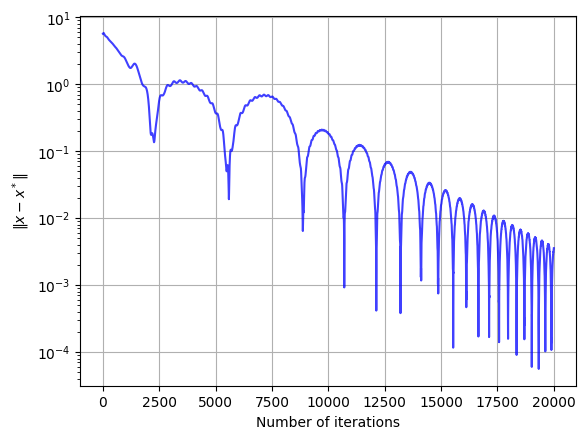

In [10]:
iterations = 20000
lr = 0.05

distance_adam_0999, iterates_adam_0999 = adam_distance(x=-3.0, y=5.0, num_iterations=iterations, beta1=0.999, beta2=0.999, lr=lr)

plt.semilogy()
plt.grid()
plt.plot(distance_adam_0999, color='blue', alpha=0.75)

plt.xlabel('Number of iterations')
plt.ylabel(r'$\|x - x^*\|$')
plt.show()

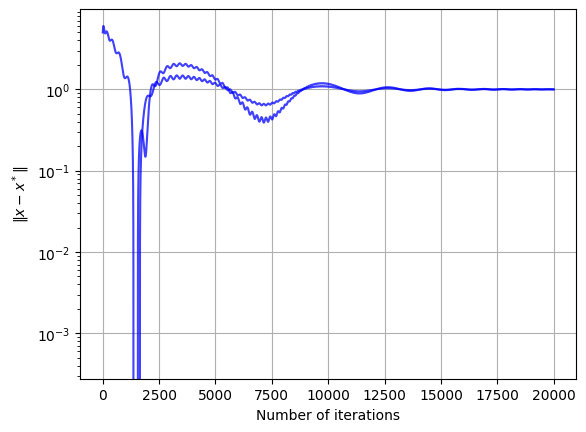

In [11]:
plt.semilogy()
plt.grid()
plt.plot(iterates_adam_0999, color='blue', alpha=0.75)

plt.xlabel('Number of iterations')
plt.ylabel(r'$\|x - x^*\|$')
plt.show()

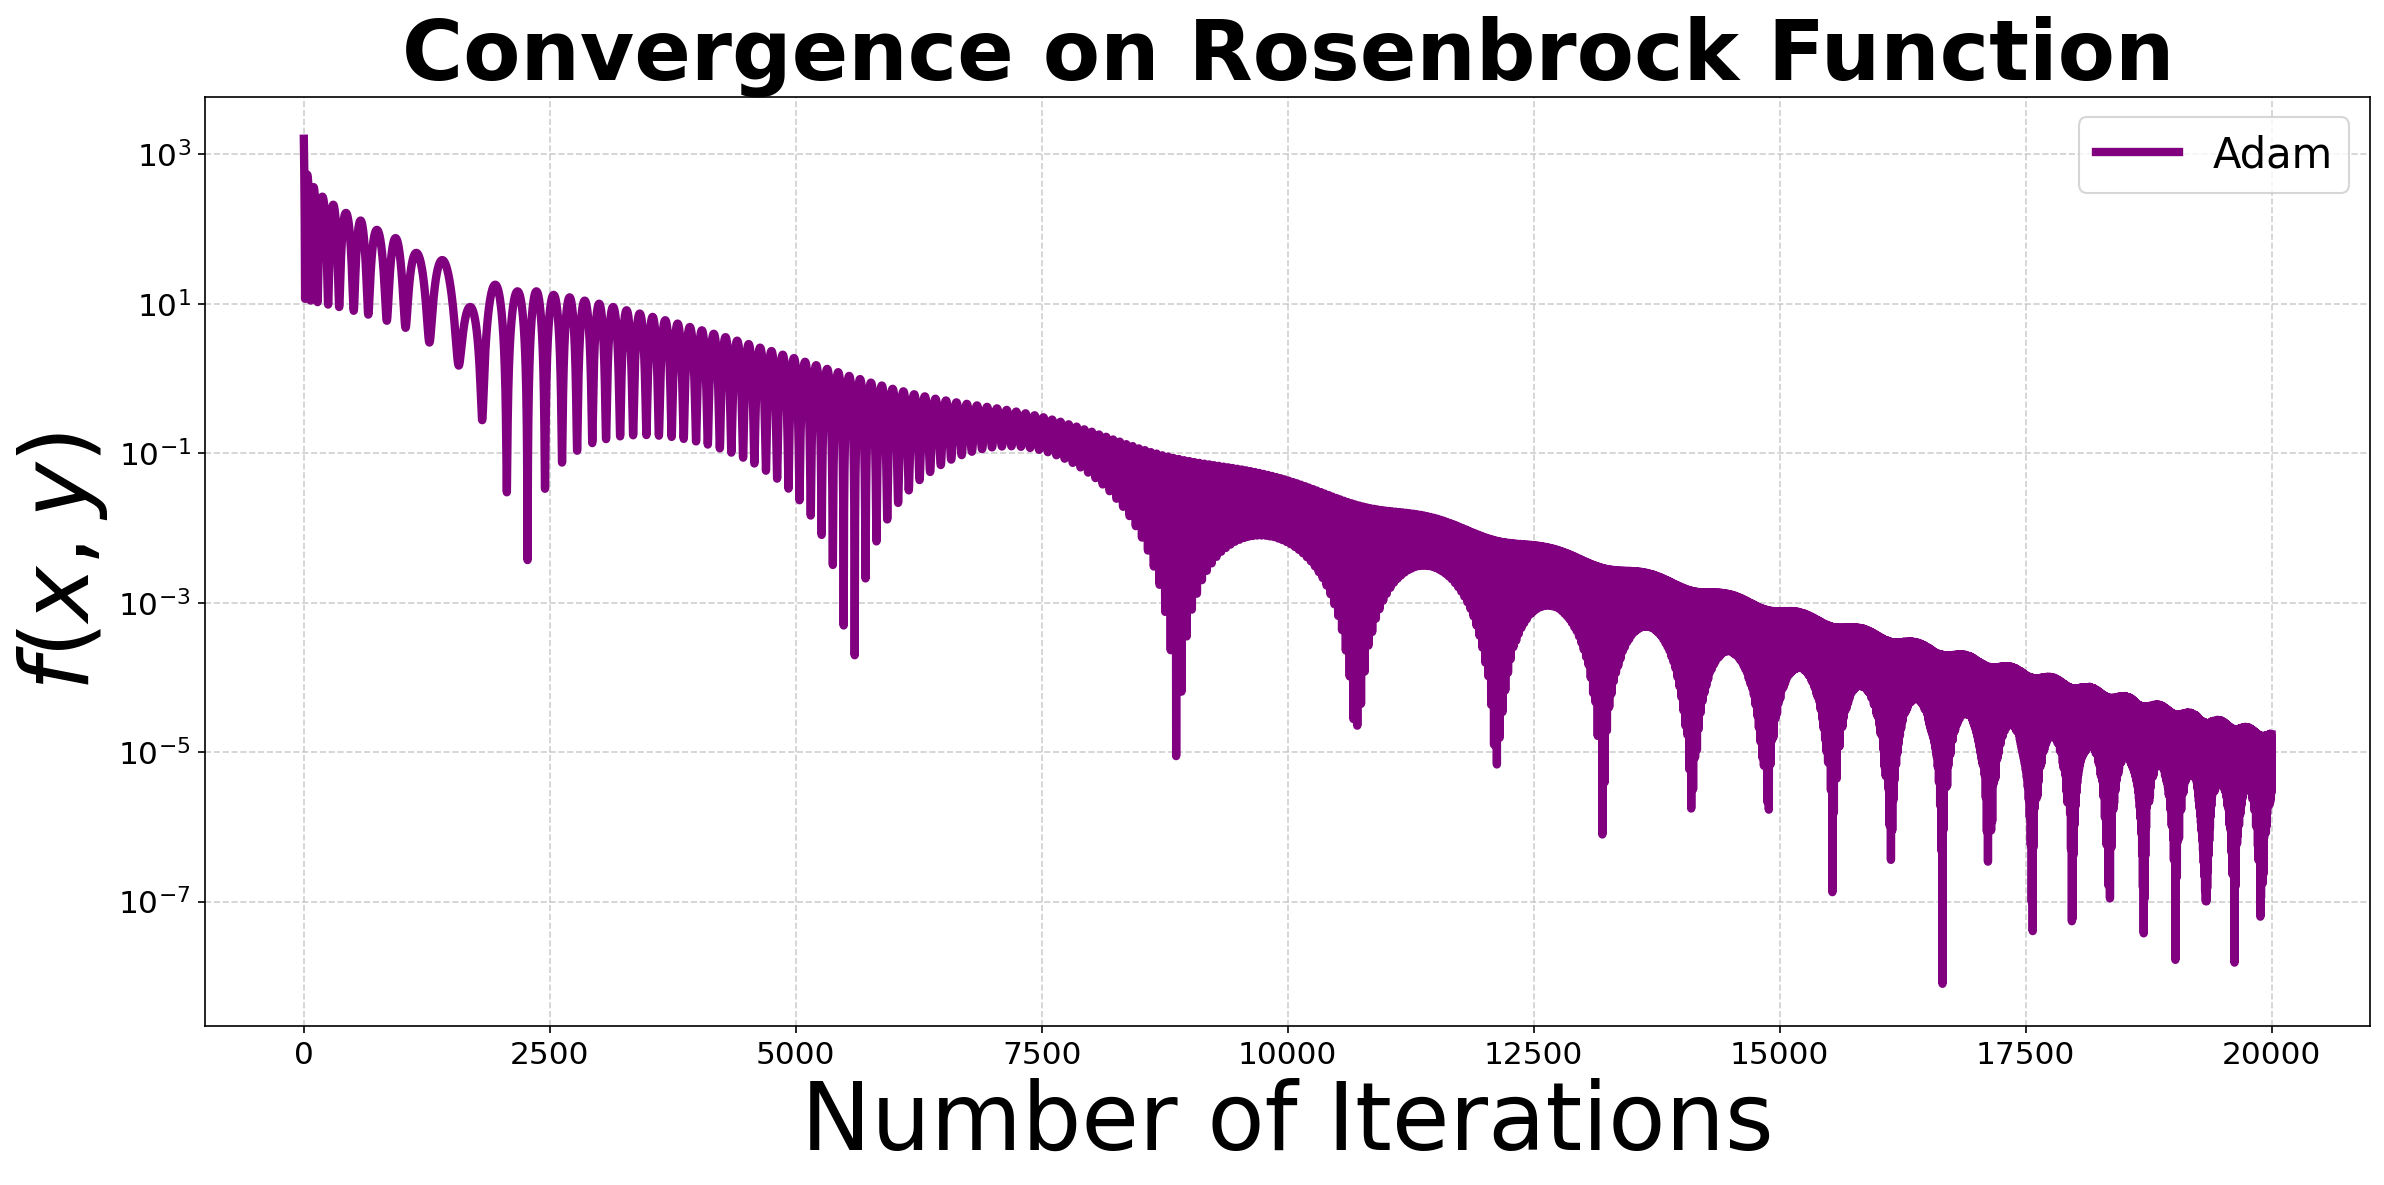

In [12]:
plot_convergence(
    distances_list=[distance_adam_0999],
    iterates_list=[iterates_adam_0999],
    labels=['Adam'] ,
    title='Convergence on Rosenbrock Function',
    logscale=True,
    custom_colors={'Adam': 'purple'},
    linewidth=4.0,
    plot_type='function',  # 'distance', 'iterates', or 'function'
)

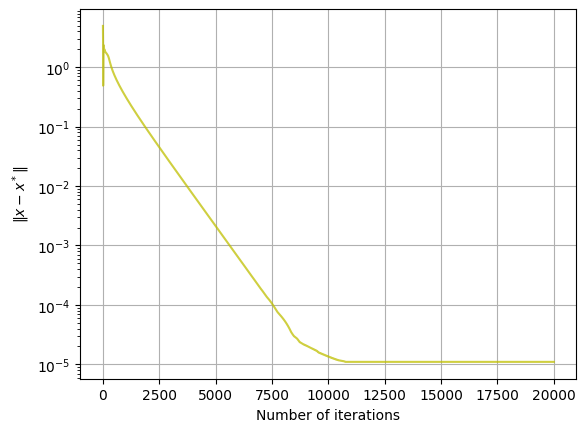

In [13]:
iterations = 20000
lr = 3e-4

distance_sgd, iterates_sgd = sgd_distance(x=-3.0, y=5.0, num_iterations=iterations, lr=lr, momentum=0.9)

plt.semilogy()
plt.grid()
plt.plot(distance_sgd, color='y', alpha=0.75)

plt.xlabel('Number of iterations')
plt.ylabel(r'$\|x - x^*\|$')
plt.show()

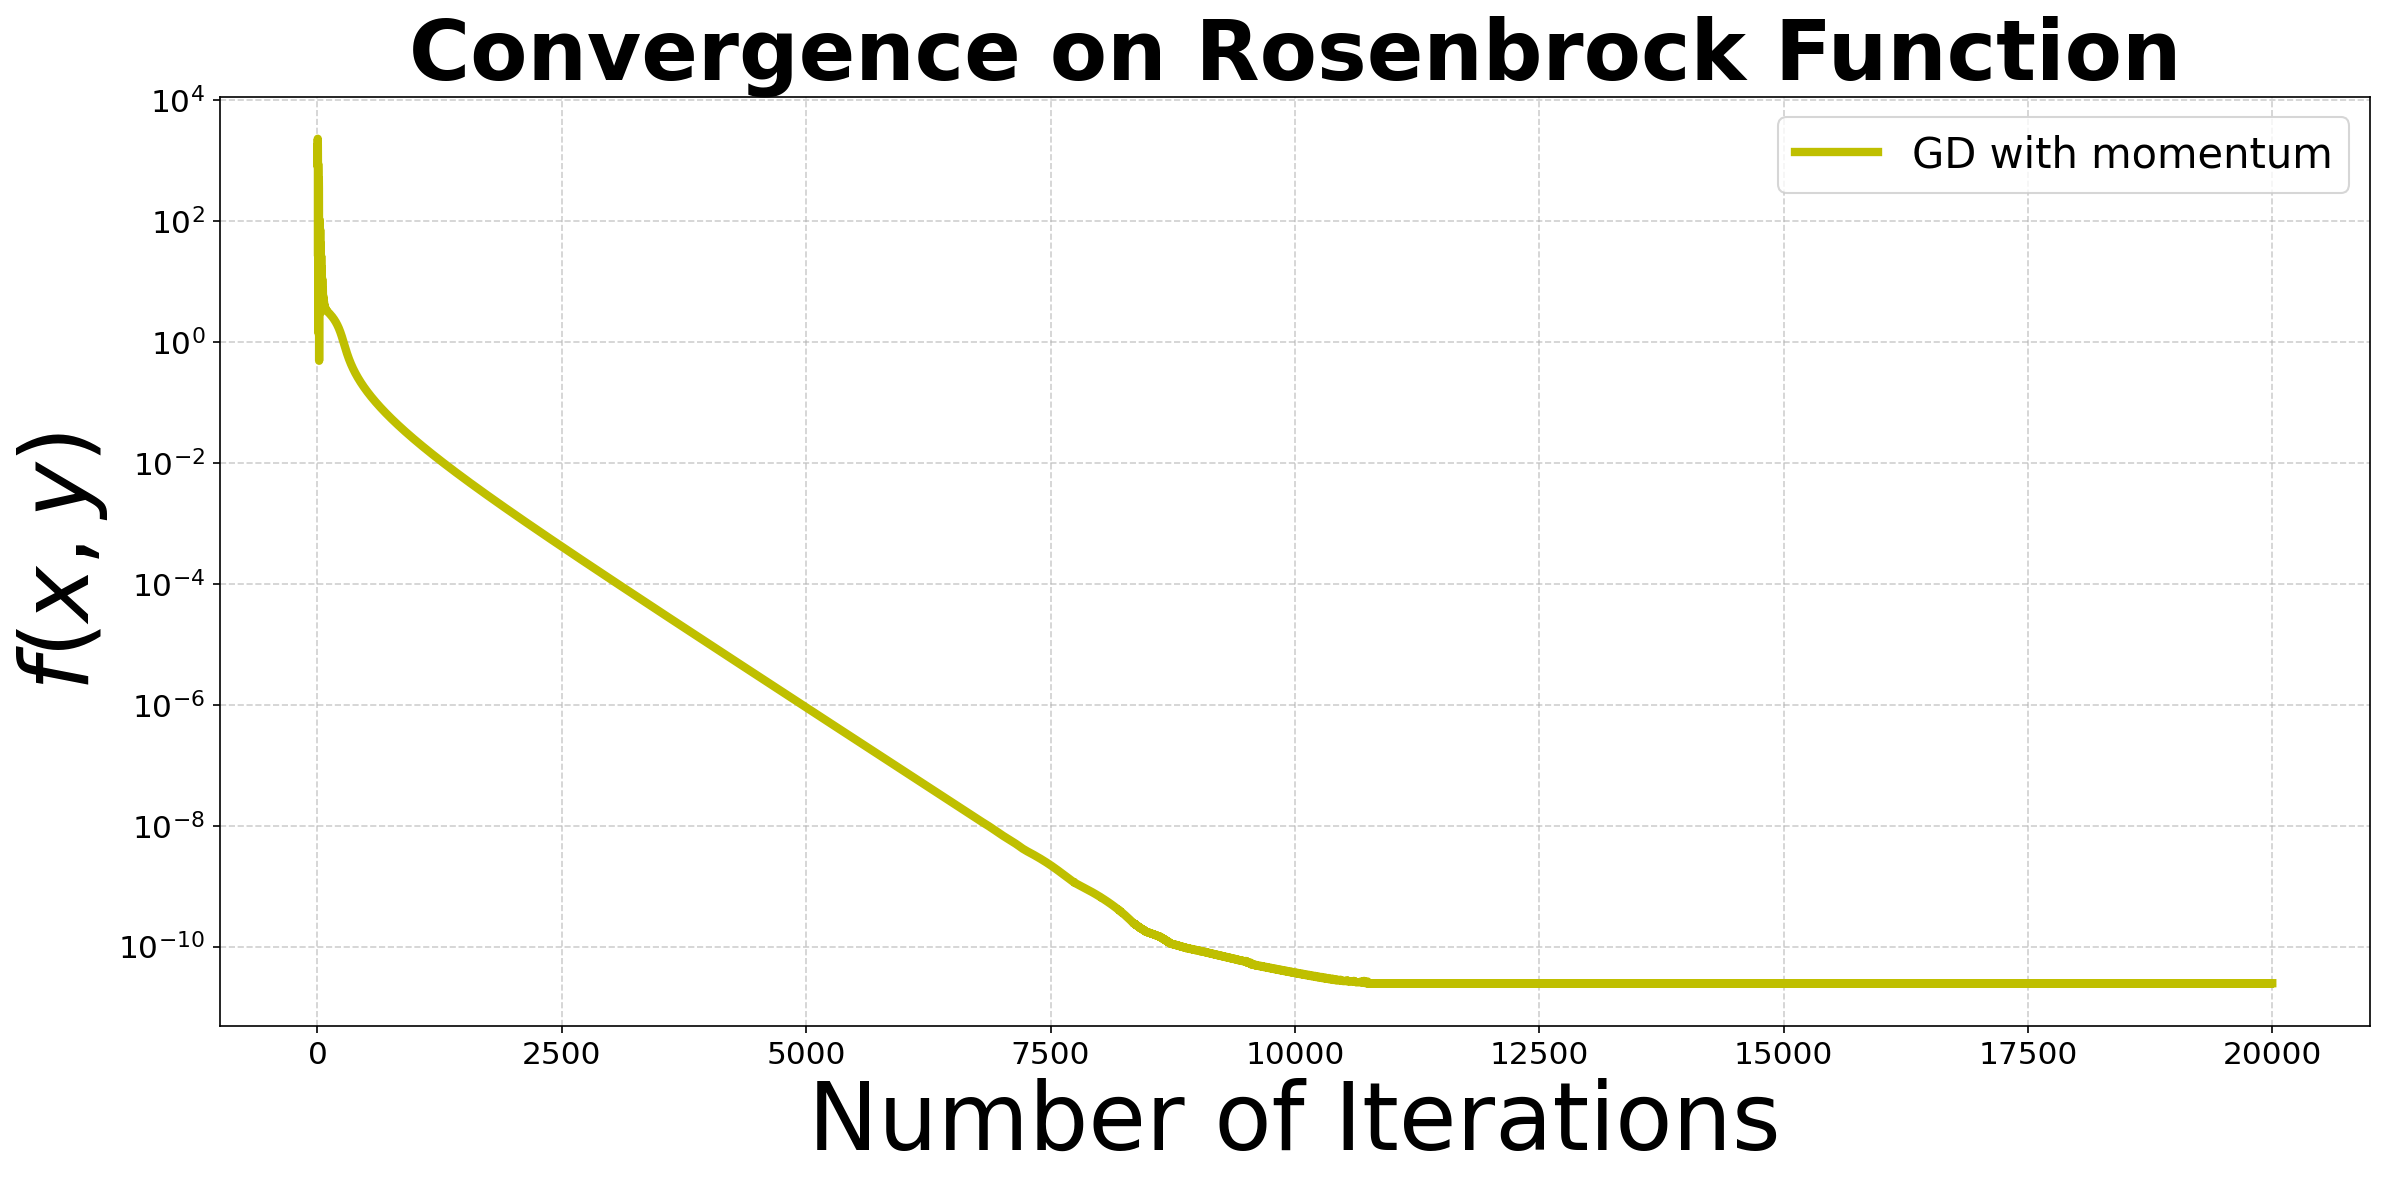

In [38]:
plot_convergence(
    distances_list=[distance_sgd],
    iterates_list=[iterates_sgd],
    labels=['GD with momentum'] ,
    title='Convergence on Rosenbrock Function',
    logscale=True,
    custom_colors={'GD with momentum': 'y'},
    linewidth=4.0,
    plot_type='function',  # 'distance', 'iterates', or 'function'
)

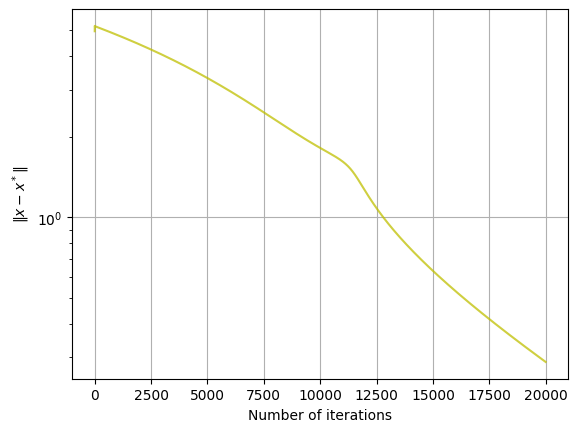

In [36]:
iterations = 20000
lr = 3e-4

distance_sgd_mom_0, iterates_sgd_mom_0 = sgd_distance(x=-3.0, y=5.0, num_iterations=iterations, lr=lr, momentum=0.0)

plt.semilogy()
plt.grid()
plt.plot(distance_sgd_mom_0, color='y', alpha=0.75)

plt.xlabel('Number of iterations')
plt.ylabel(r'$\|x - x^*\|$')
plt.show()

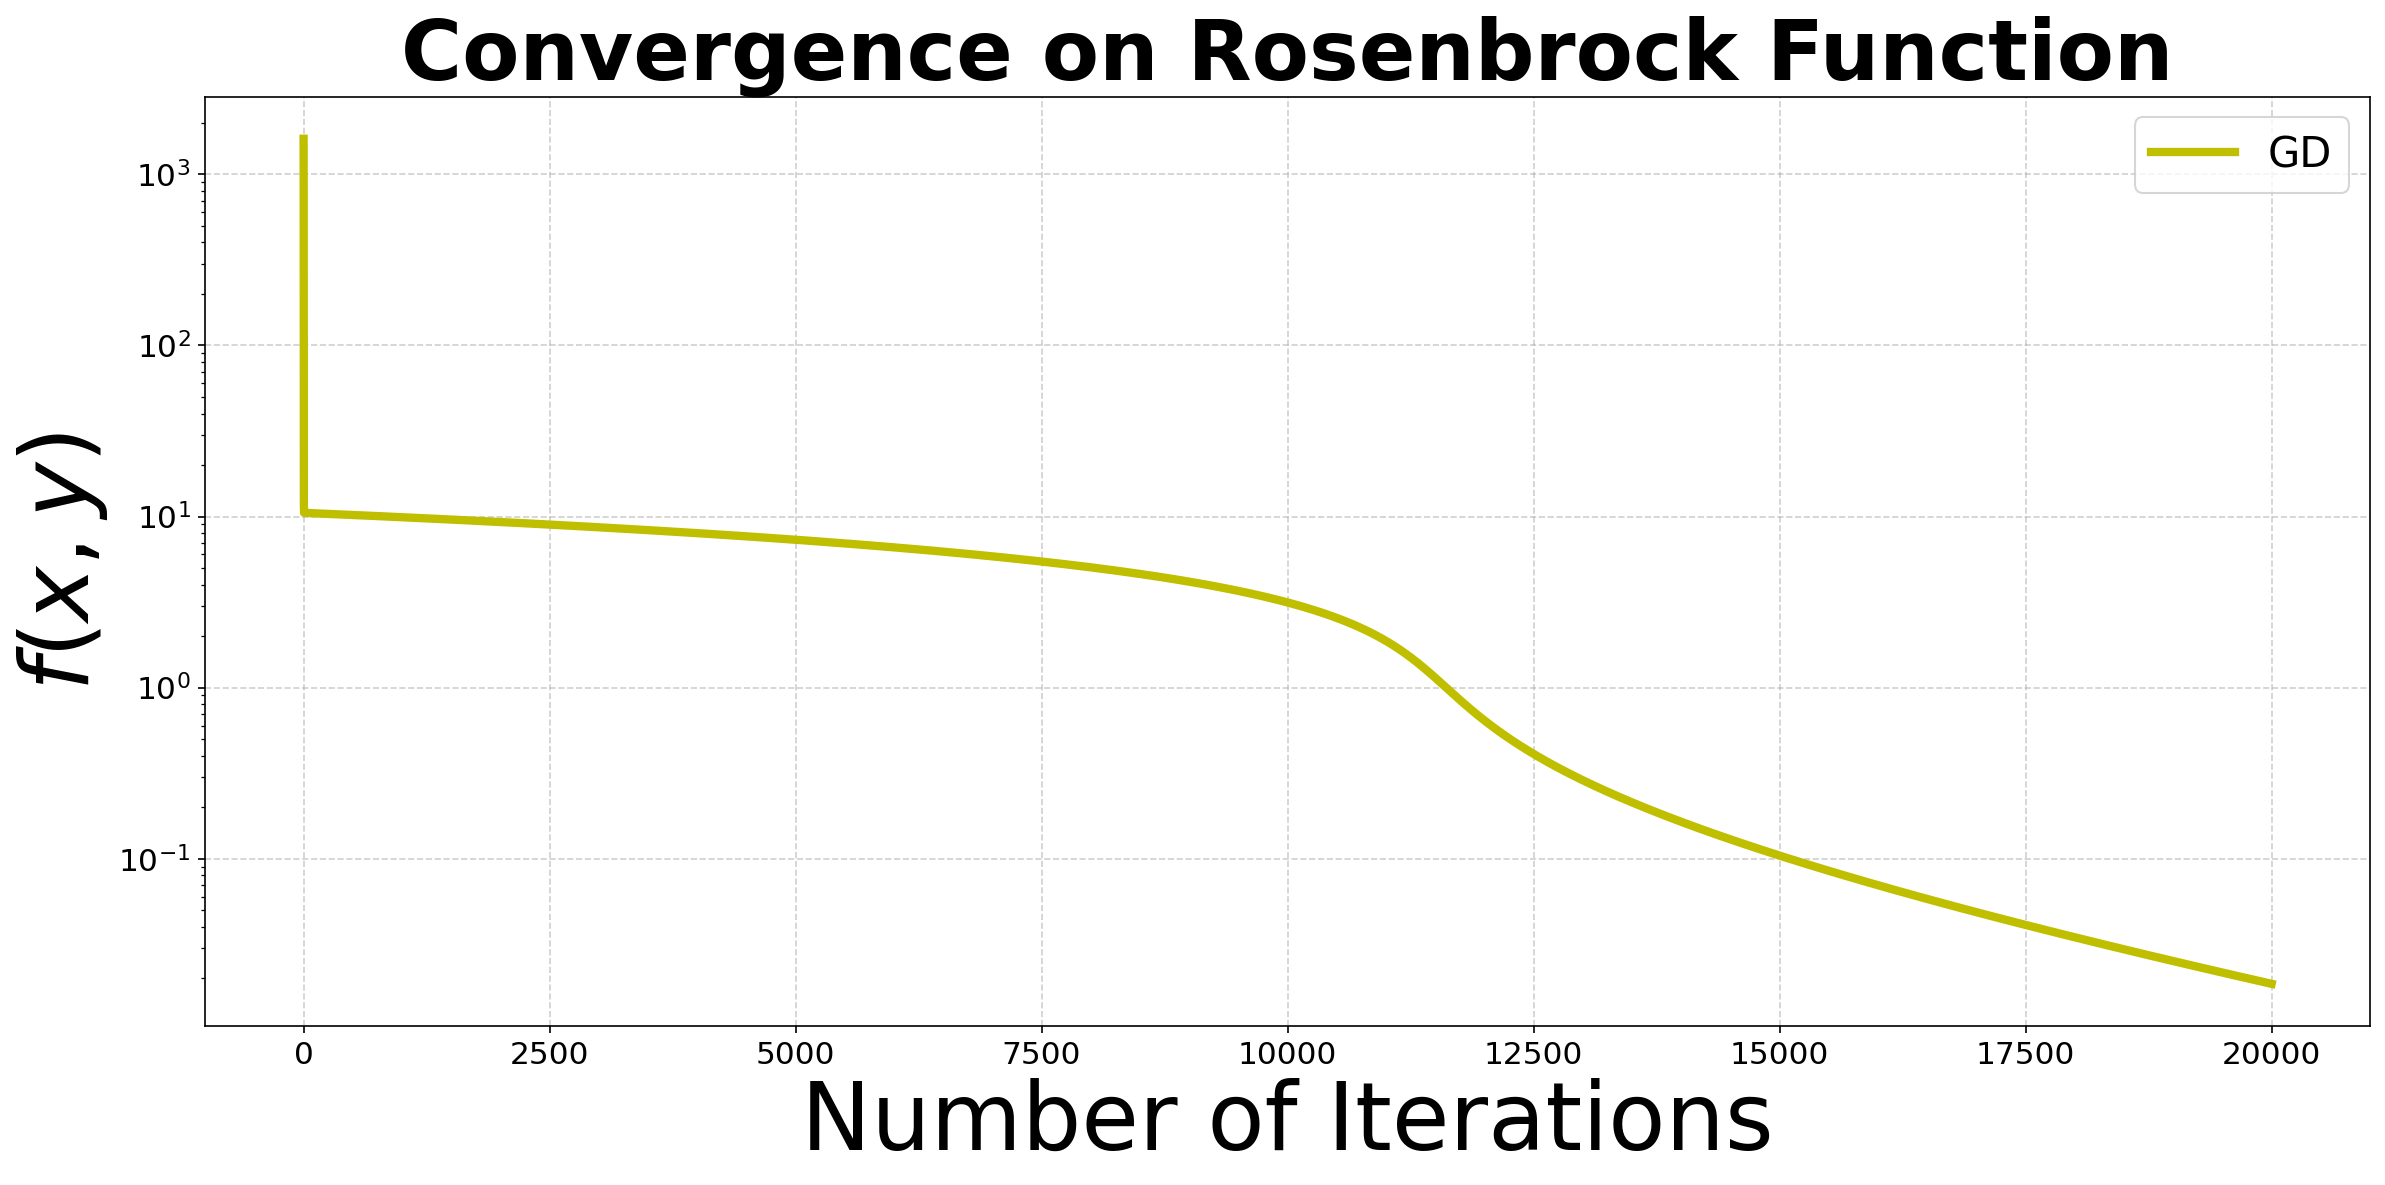

In [37]:
plot_convergence(
    distances_list=[distance_sgd_mom_0],
    iterates_list=[iterates_sgd_mom_0],
    labels=['GD'] ,
    title='Convergence on Rosenbrock Function',
    logscale=True,
    custom_colors={'GD': 'y'},
    linewidth=4.0,
    plot_type='function',  # 'distance', 'iterates', or 'function'
)

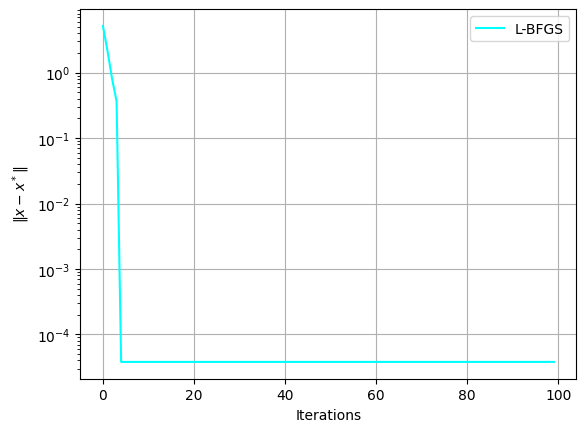

In [39]:
distance_lbfgs, iterates_lbfgs = lbfgs_distance(
    x=-3.0, 
    y=5.0, 
    num_iterations=100,
    lr=0.5, 
    history_size=50,
    device="cuda:0"
)

plt.semilogy(distance_lbfgs, color='cyan', label='L-BFGS')
plt.grid()
plt.xlabel('Iterations')
plt.ylabel(r'$\|x - x^*\|$')
plt.legend()
plt.show()

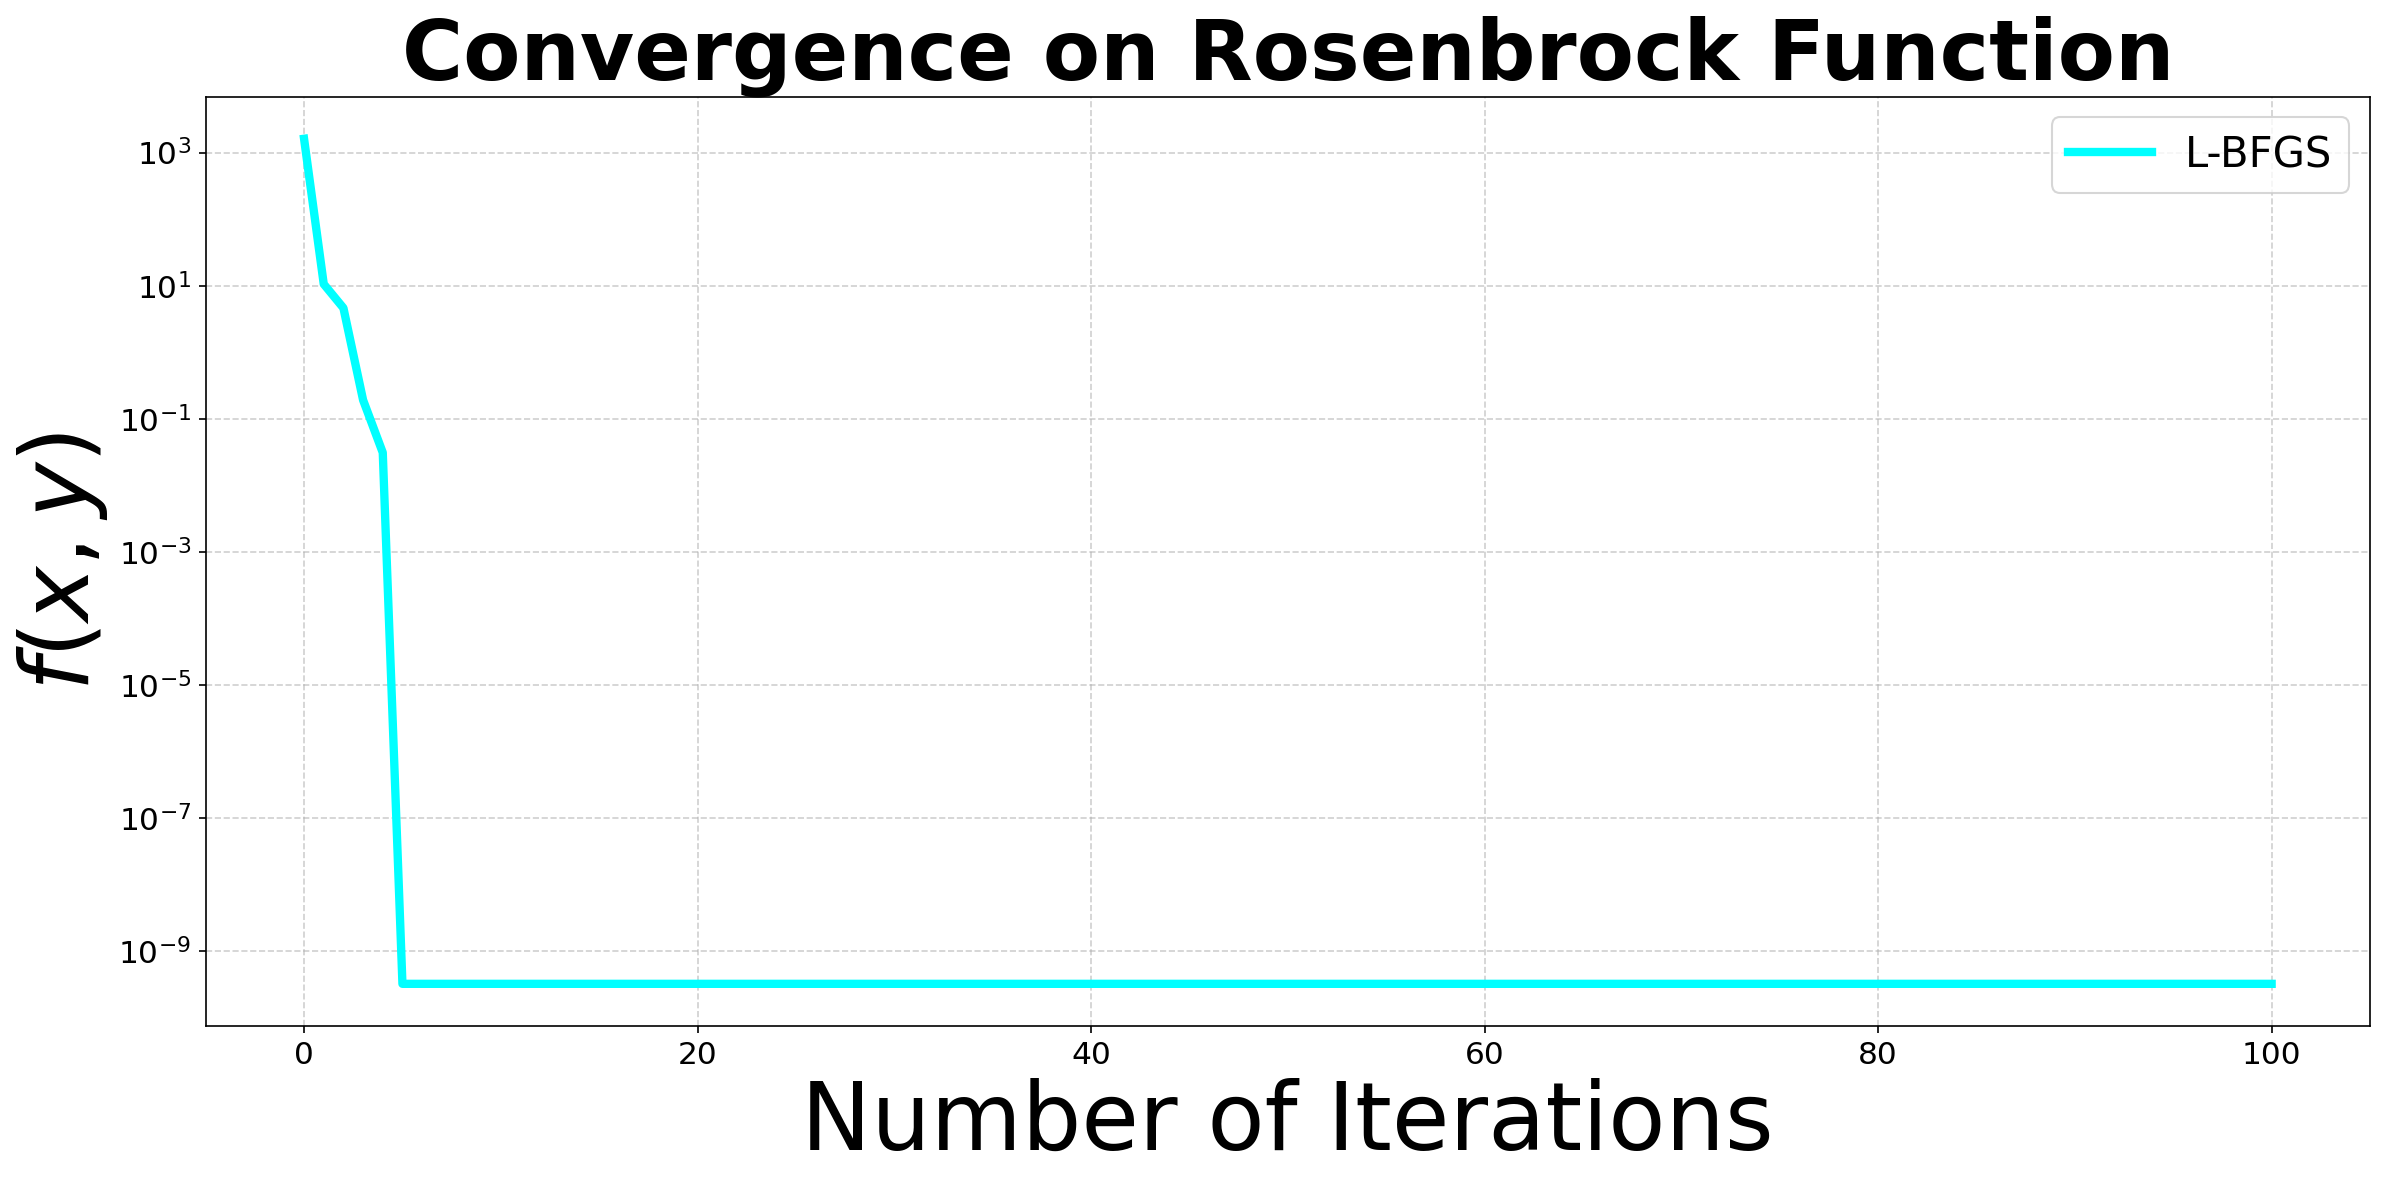

In [40]:
plot_convergence(
    distances_list=[distance_lbfgs],
    iterates_list=[iterates_lbfgs],
    labels=['L-BFGS'] ,
    title='Convergence on Rosenbrock Function',
    logscale=True,
    custom_colors={'L-BFGS': 'cyan'},
    linewidth=4.0,
    plot_type='function',  # 'distance', 'iterates', or 'function'
)

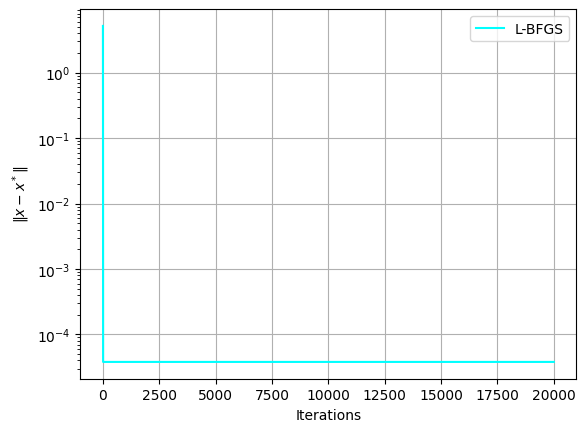

In [41]:
distance_lbfgs_long, iterates_lbfgs_long = lbfgs_distance(
    x=-3.0, 
    y=5.0, 
    num_iterations=20000,
    lr=0.5, 
    history_size=50,
    device="cuda:0"
)

plt.semilogy(distance_lbfgs_long, color='cyan', label='L-BFGS')
plt.grid()
plt.xlabel('Iterations')
plt.ylabel(r'$\|x - x^*\|$')
plt.legend()
plt.show()

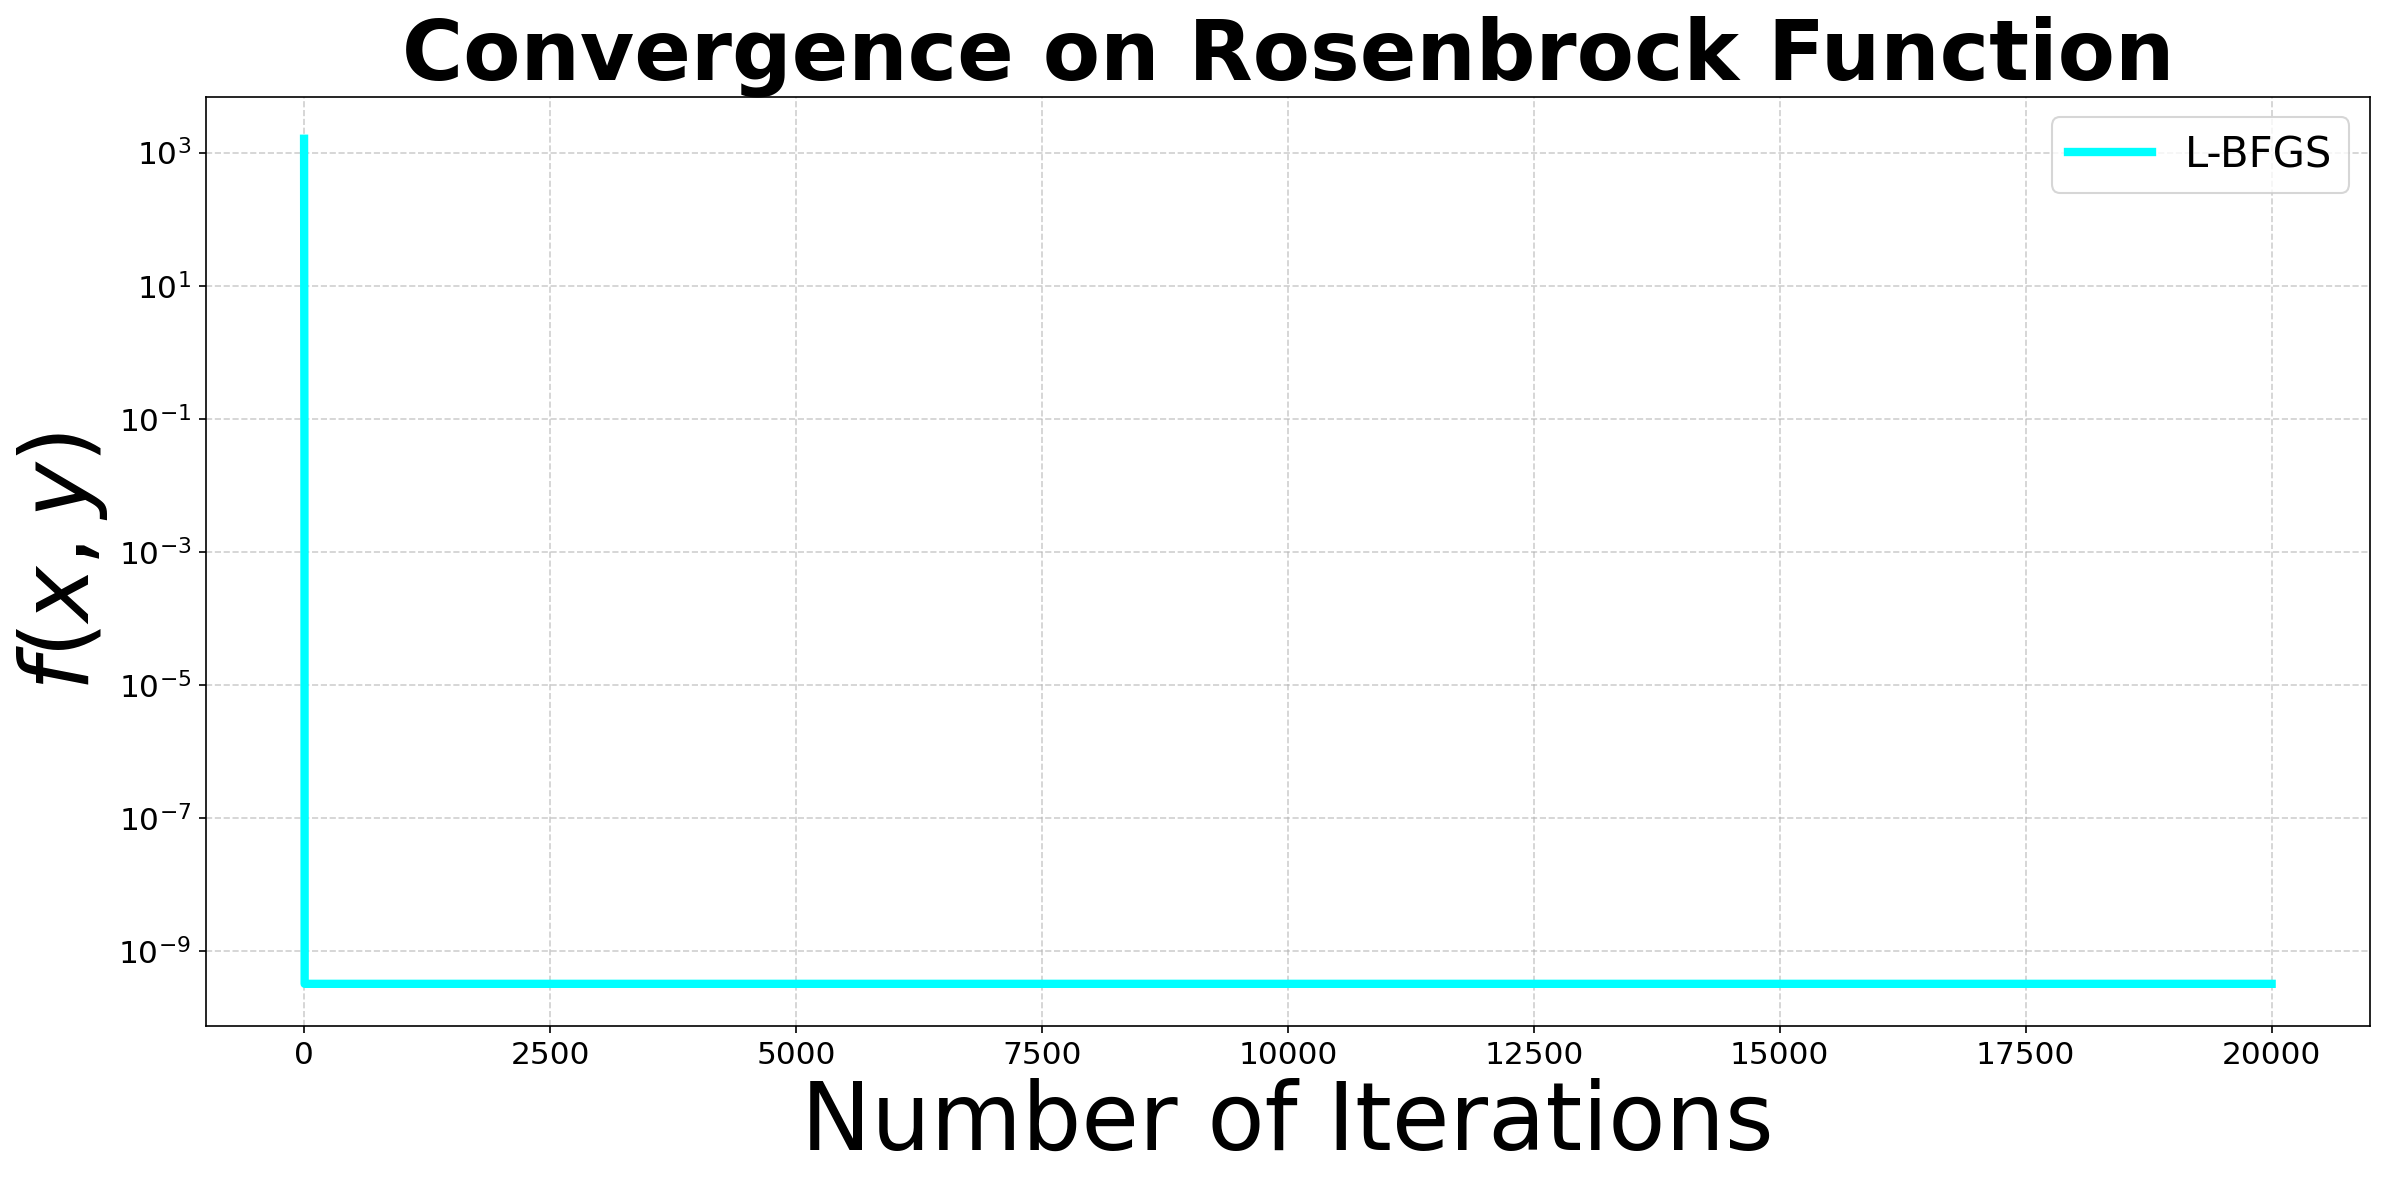

In [43]:
plot_convergence(
    distances_list=[distance_lbfgs_long],
    iterates_list=[iterates_lbfgs_long],
    labels=['L-BFGS'] ,
    title='Convergence on Rosenbrock Function',
    logscale=True,
    custom_colors={'L-BFGS': 'cyan'},
    linewidth=4.0,
    plot_type='function',  # 'distance', 'iterates', or 'function'
)

## hat rosenbrock

In [52]:
import numpy as np
from scipy.optimize import minimize

In [53]:
def rosenbrock_fn(x, a=1, b=100):
    return (a - x[0])**2 + b * (x[1] - x[0]**2)**2

def rosenbrock_grad(x, a=1, b=100):
    dfdx = -2*(a - x[0]) - 4*b * x[0] * (x[1] - x[0]**2)
    dfdy = 2*b * (x[1] - x[0]**2)
    return np.array([dfdx, dfdy])

def rosenbrock_hessian(x, a=1, b=100):
    h11 = 2 - 4*b*(x[1] - 3*x[0]**2)
    h12 = -4*b*x[0]
    h21 = h12
    h22 = 2*b
    return np.array([[h11, h12], [h21, h22]])

def get_r_k(xi, hess_diffs_norm, grad_norm, L_hess, L_rho, eta, sigma):
    b_term = hess_diffs_norm / np.sqrt(grad_norm) + L_rho * hess_diffs_norm / (2 * (2 * sigma - L_rho))
    a_term = L_hess / 3 + L_rho * (2 * eta + L_hess / 3) / (2 * sigma - L_rho)
    return xi / (b_term + np.sqrt(a_term * xi))

def get_A_k(r_k, L_hess, L_rho, hess_diffs_norm, grad_norm, eta, sigma):
    tilde_sigma = 2 * sigma - L_rho
    A_k = hess_diffs_norm / (2 * tilde_sigma) + r_k * np.sqrt(grad_norm) * (2 * eta + L_hess / 3) / tilde_sigma
    return A_k

def objective(d, grad_f, H_k, A_k):
    grad_term = np.dot(grad_f, d)
    hess_term = 0.5 * np.dot(d.T, np.dot(H_k, d))
    reg_term = 0.5 * A_k * np.linalg.norm(d)**2
    return grad_term + hess_term + reg_term

def constraint(d, grad_f, r_k):
    return r_k**2 * np.linalg.norm(grad_f) - np.linalg.norm(d)**2

def hat_rosenbrock(x0, num_iters=50, a=1, b=100, L_hess=200, L_rho=2.0, eta=1.5, sigma=1.666666666666665, xi=0.5):
    x_k = x0.copy()
    history = [x0.copy()]
    
    for _ in range(num_iters):
        grad_f = rosenbrock_grad(x_k, a, b)
        grad_norm = np.linalg.norm(grad_f)
        
        H_k = rosenbrock_hessian(x_k, a, b)
        hess_diff_norm = 0.0
        
        r_k = get_r_k(xi, hess_diff_norm, grad_norm, L_hess, L_rho, eta, sigma)
        A_k = get_A_k(r_k, L_hess, L_rho, hess_diff_norm, grad_norm, eta, sigma)
        
        cons = {'type': 'ineq', 'fun': constraint, 'args': (grad_f, r_k)}
        result = minimize(objective, np.zeros_like(x_k), args=(grad_f, H_k, A_k),
                          constraints=cons, method='SLSQP')
        d_k = result.x
        
        x_k += d_k
        history.append(x_k.copy())
    
    return np.array(history)

def gradient_descent(x0, grad_func, learning_rate=0.001, num_iters=50):
    x = x0.copy()
    history = [x.copy()]
    for _ in range(num_iters):
        grad = grad_func(x)
        x -= learning_rate * grad
        history.append(x.copy())
    return np.array(history)

def newton_method(x0, grad_func, hess_func, num_iters=50):
    x = x0.copy()
    history = [x.copy()]
    for _ in range(num_iters):
        grad = grad_func(x)
        hess_inv = np.linalg.inv(hess_func(x))
        x -= hess_inv @ grad
        history.append(x.copy())
    return np.array(history)

def bfgs_method(x0, func, grad_func, num_iters=50):
    result = minimize(func, x0, method='BFGS', jac=grad_func,
                      options={'maxiter': num_iters, 'return_all': True})
    return result.allvecs

In [54]:
hat_history = hat_rosenbrock(x0=np.array([-3.0, 5.0]), num_iters=20000,  L_hess=200, L_rho=2.0, eta=1.5, sigma=1.666666666666665, xi=0.5)

In [56]:
hat_history_save = hat_history

In [57]:
hat_iterates = hat_history.tolist()
hat_distances = [np.linalg.norm(point - np.array([1.0, 1.0])) for point in hat_history]

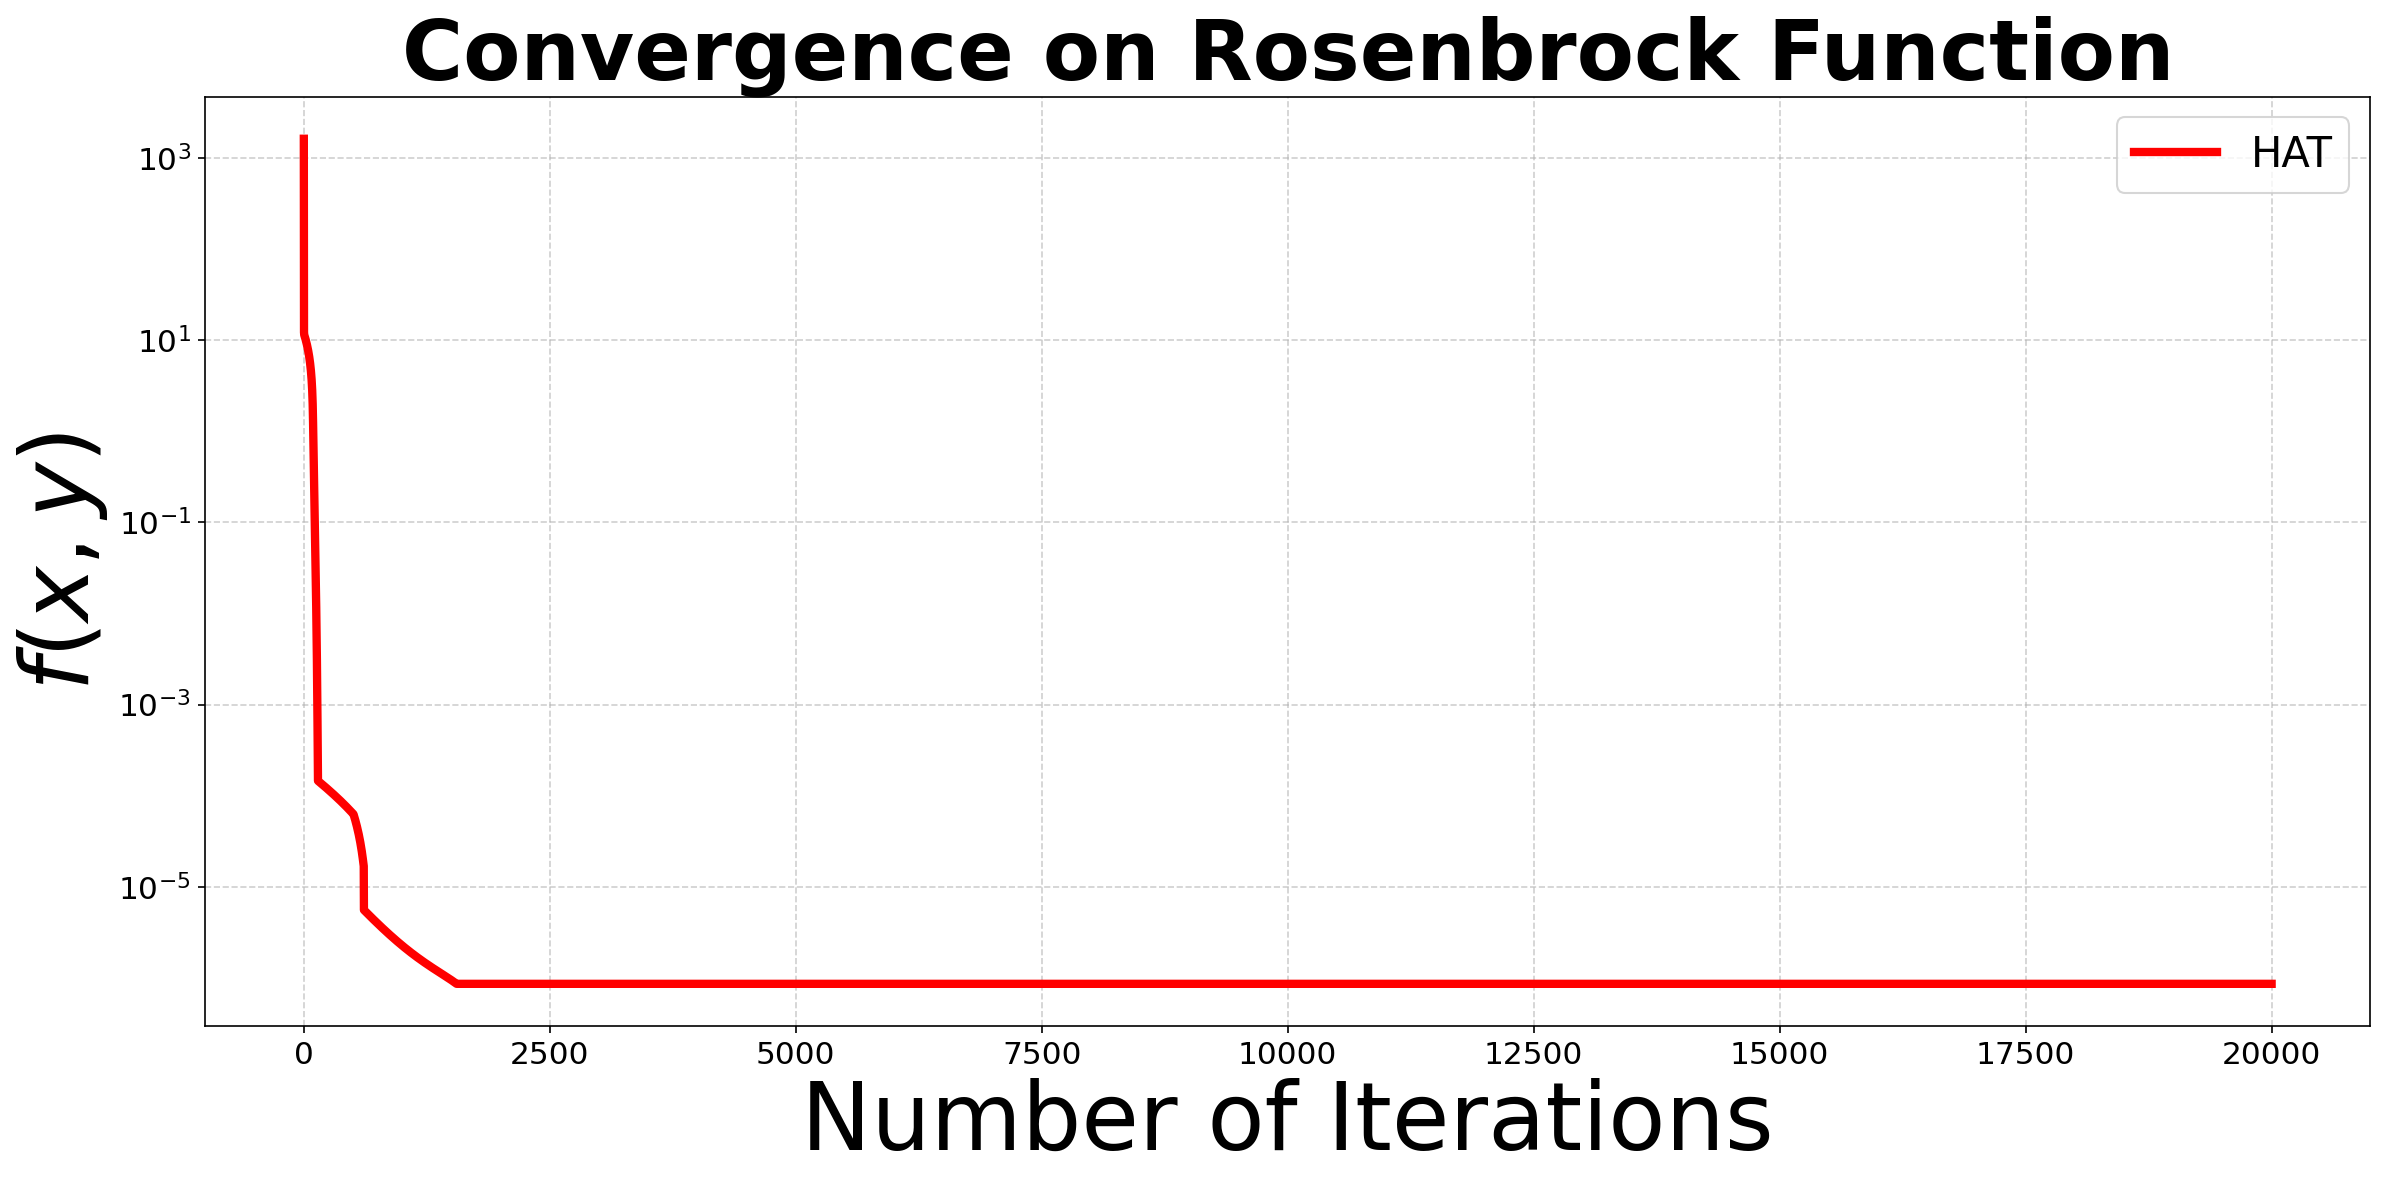

In [59]:
plot_convergence(
    distances_list=[hat_distances],
    iterates_list=[hat_iterates],
    labels=['HAT'] ,
    title='Convergence on Rosenbrock Function',
    logscale=True,
    linewidth=4.0,
    plot_type='function',  # 'distance', 'iterates', or 'function'
)

In [63]:
newt_arr = np.array([-3.0, 5.0])
newt_num_iters=20000
newton_history = newton_method(newt_arr, lambda x: rosenbrock_grad(x), lambda x: rosenbrock_hessian(x), newt_num_iters)

In [68]:
newt_arr = np.array([-3.0, 5.0])
newt_num_iters_short=1000
newton_history_short = newton_method(newt_arr, lambda x: rosenbrock_grad(x), lambda x: rosenbrock_hessian(x), newt_num_iters_short)

In [66]:
newton_iterates = newton_history.tolist()
newton_distances = [np.linalg.norm(point - np.array([1.0, 1.0])) for point in newton_history]

In [69]:
newton_iterates_short = newton_history_short.tolist()
newton_distances_short = [np.linalg.norm(point - np.array([1.0, 1.0])) for point in newton_history_short]

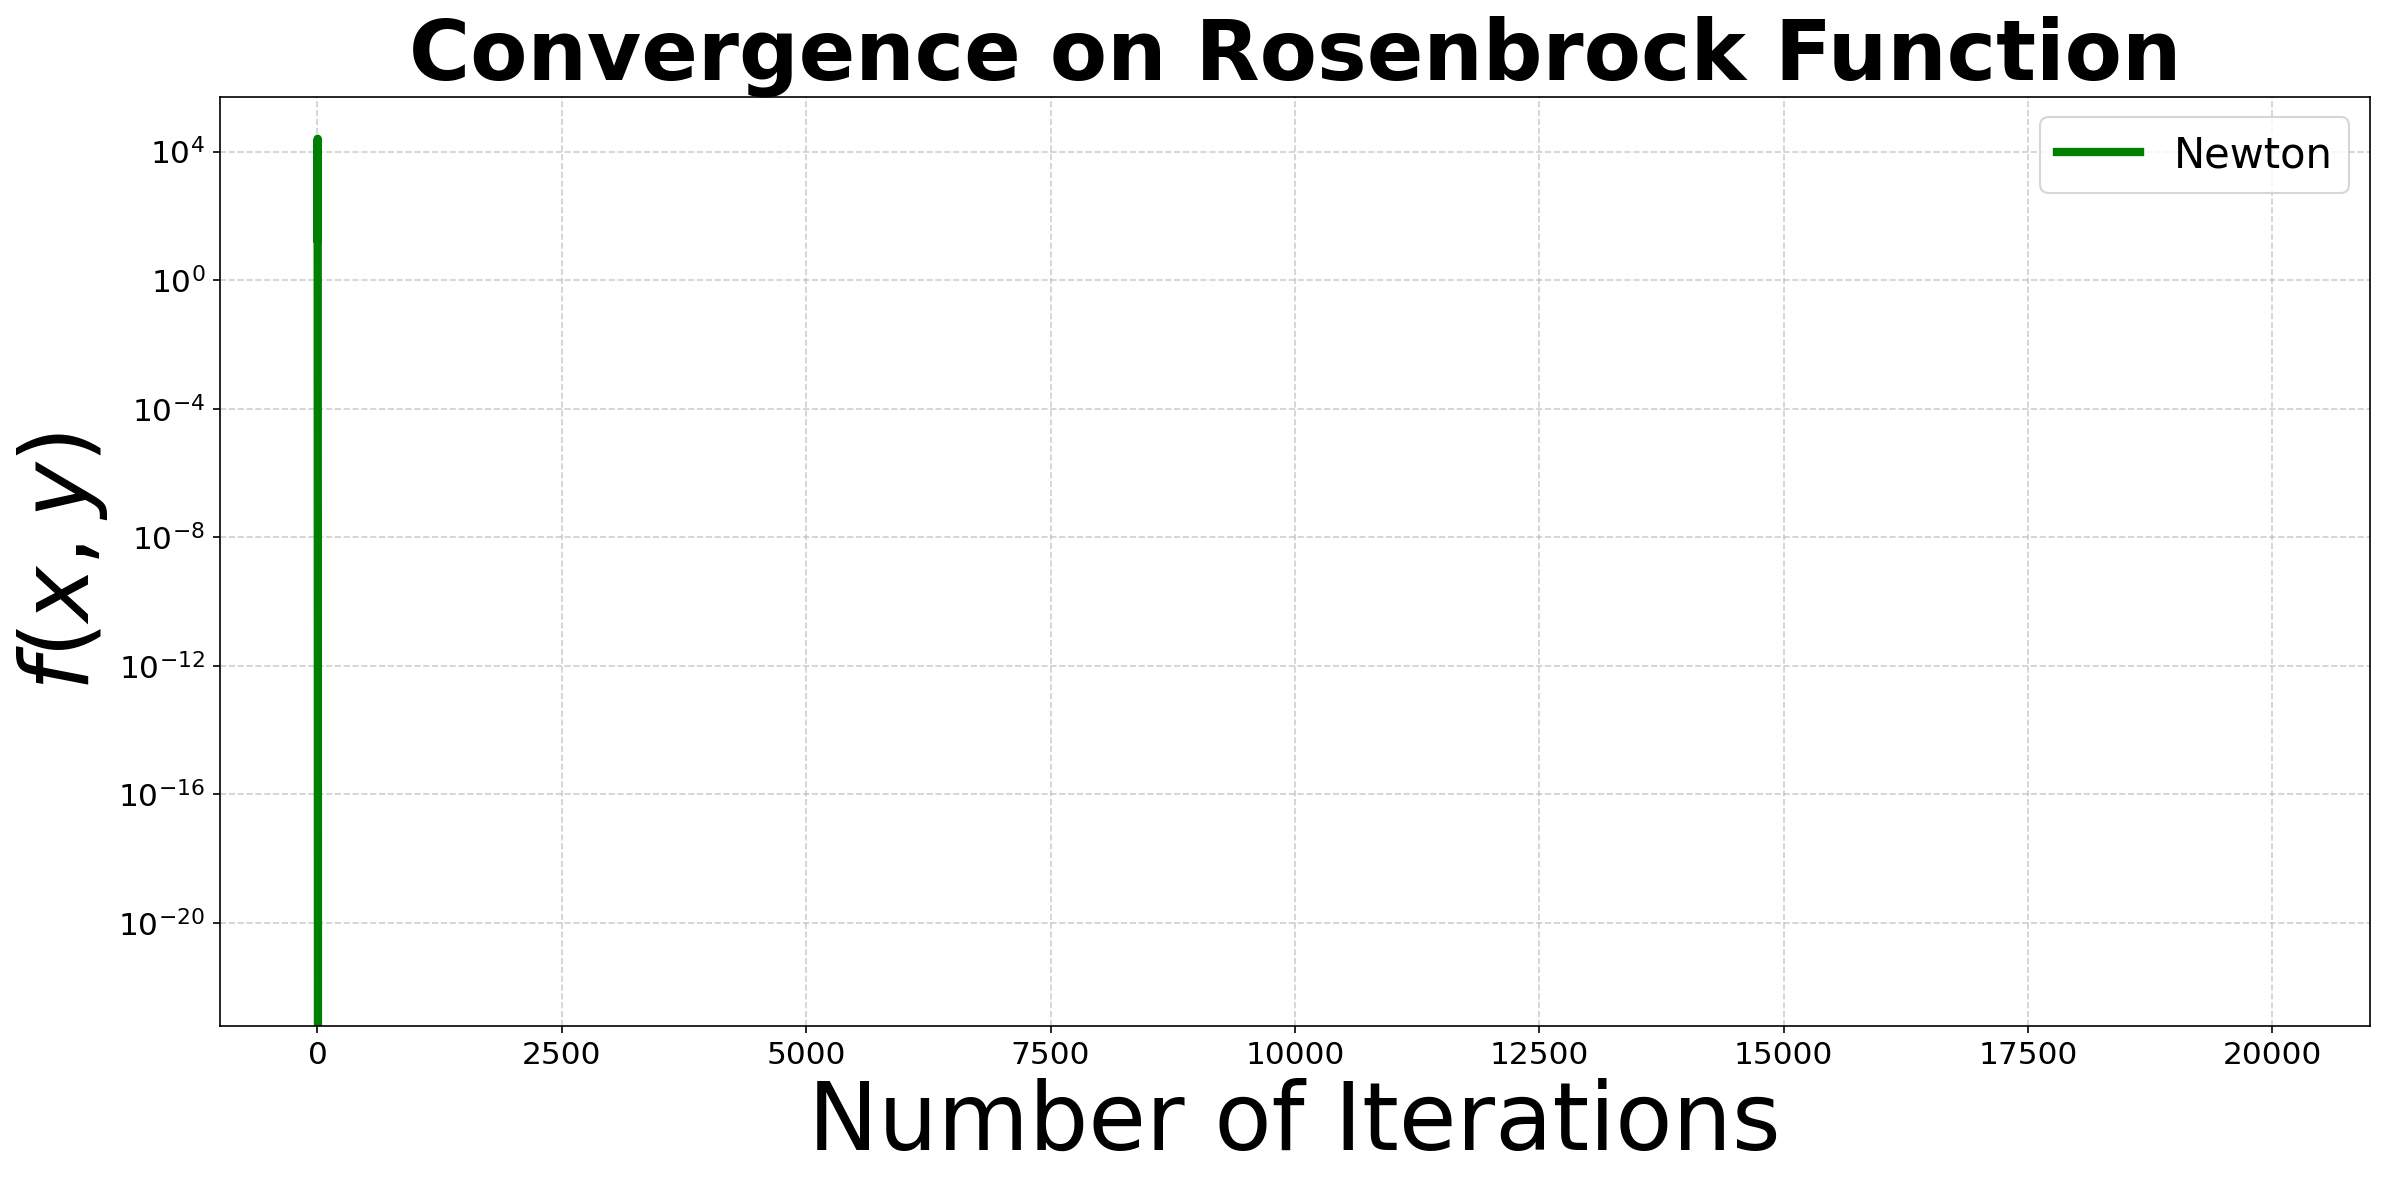

In [67]:
plot_convergence(
    distances_list=[newton_distances],
    iterates_list=[newton_iterates],
    labels=['Newton'] ,
    title='Convergence on Rosenbrock Function',
    logscale=True,
    linewidth=4.0,
    plot_type='function',  # 'distance', 'iterates', or 'function'
)

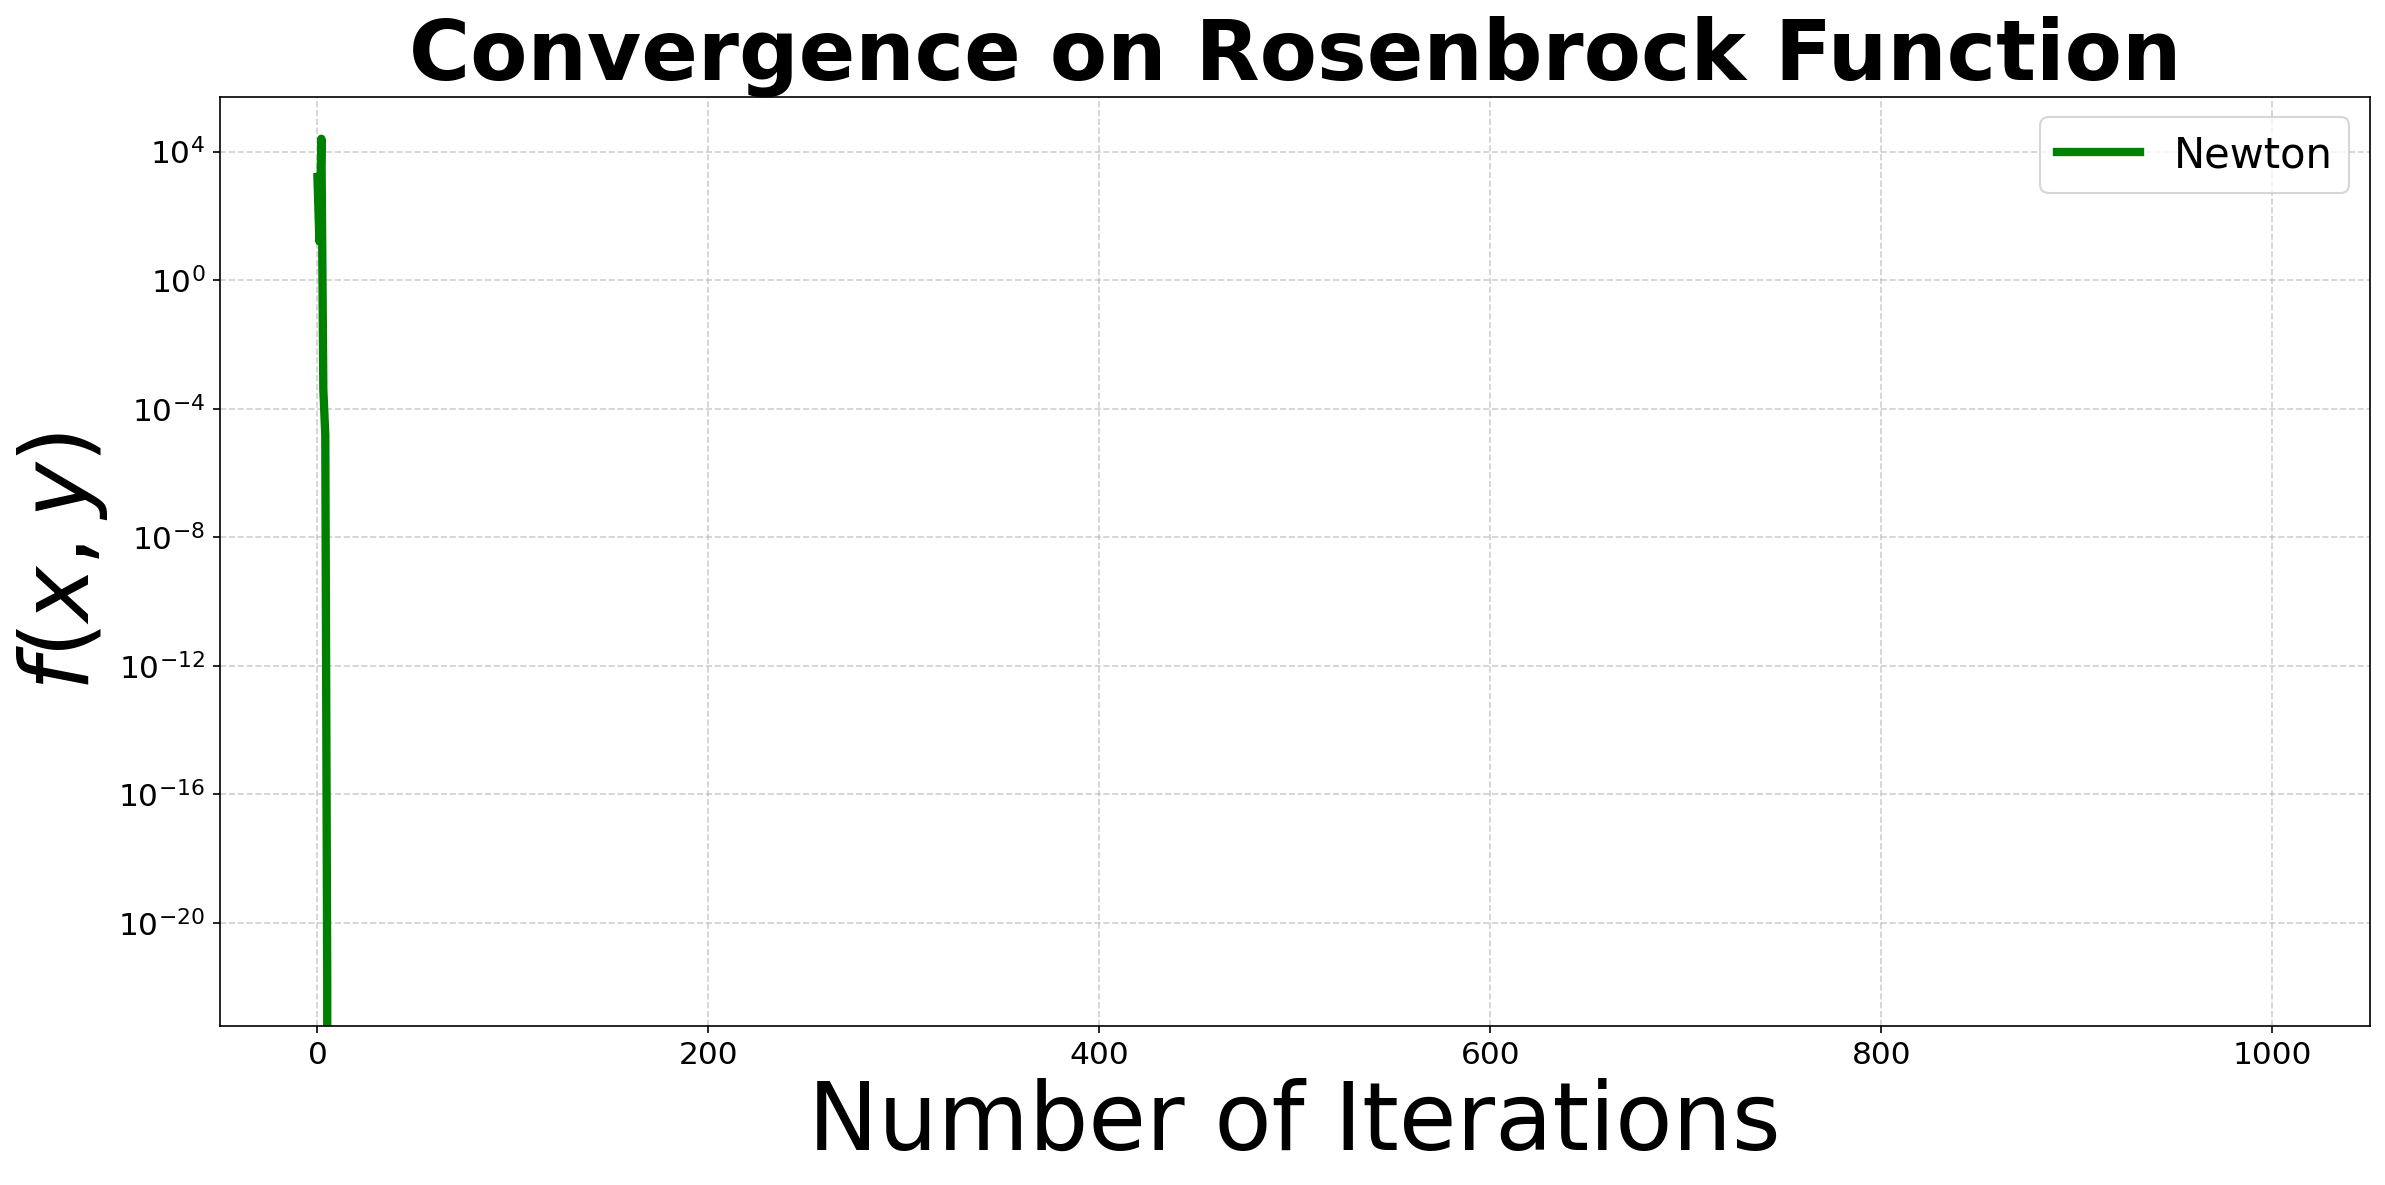

In [70]:
plot_convergence(
    distances_list=[newton_distances_short],
    iterates_list=[newton_iterates_short],
    labels=['Newton'] ,
    title='Convergence on Rosenbrock Function',
    logscale=True,
    linewidth=4.0,
    plot_type='function',  # 'distance', 'iterates', or 'function'
)

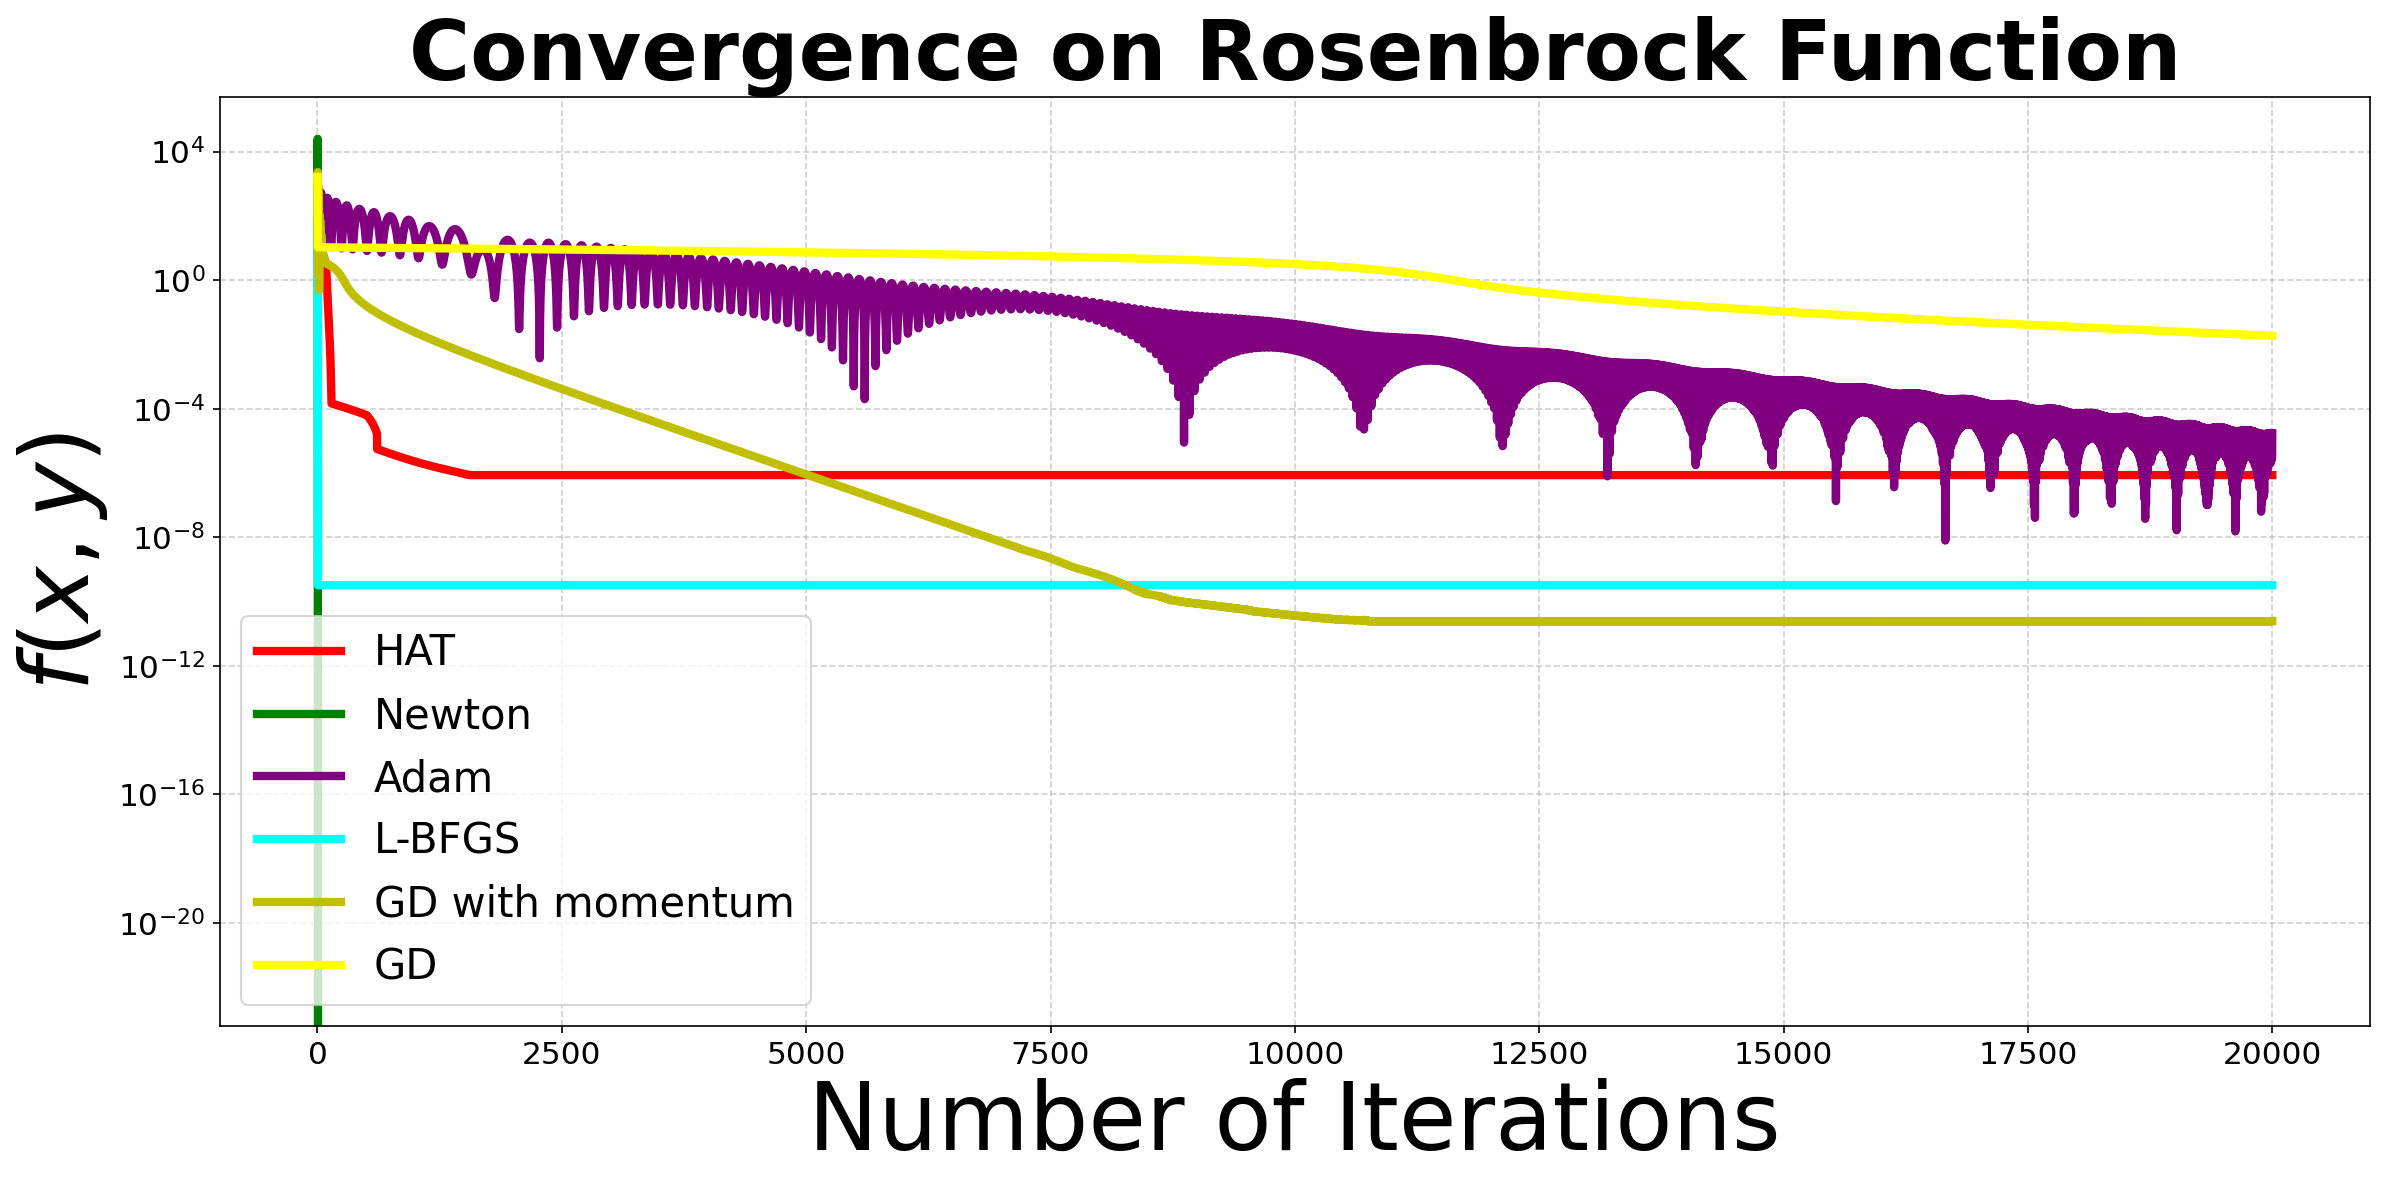

In [77]:
# histories = [hat_history, gd_history, newton_history, bfgs_history]
# labels = ['HAT', 'GD', 'Newton', 'L-BFGS']
# plt.figure(figsize=(10, 6))
# plot_convergence(histories, labels, 
#                  title='Convergence on Rosenbrock Function',
#                  logscale=True,
#                  linewidth=4,
#                 )

plot_convergence(
    distances_list=[
        hat_distances, 
        newton_distances, 
        distance_adam_0999, 
        distance_lbfgs_long,
        distance_sgd,
        distance_sgd_mom_0,
    ],
    iterates_list=[
        hat_iterates, 
        newton_iterates, 
        iterates_adam_0999, 
        iterates_lbfgs_long,
        iterates_sgd,
        iterates_sgd_mom_0,
    ],
    labels=['HAT', 'Newton', 'Adam', 'L-BFGS', 'GD with momentum', 'GD'],
    custom_colors={
        'HAT': 'r',
        'Newton': 'g',
        'Adam': 'purple',
        'L-BFGS': 'cyan',
        'GD with momentum': 'y',
        'GD': 'yellow',
    },
    title='Convergence on Rosenbrock Function',
    logscale=True,
    linewidth=4.0,
    plot_type='function',  # 'distance', 'iterates', or 'function'
)

In [78]:
def empirical_fisher_approximation_rosen(x, num_samples=50, epsilon=0.1):
    """Approximate Hessian using gradient outer products at perturbed points."""
    n = x.shape[0]
    fisher = np.zeros((n, n))
    for _ in range(num_samples):
        perturbation = np.random.normal(loc=0, scale=epsilon, size=n)
        x_perturbed = x + perturbation
        grad = rosenbrock_grad(x_perturbed)
        fisher += np.outer(grad, grad)
    return fisher / num_samples

In [79]:
def hat_rosenbrock_with_fisher(
    x0, 
    num_iters=50, 
    a=1, 
    b=100, 
    L_hess=200, 
    L_rho=2.0, 
    eta=1.5, 
    sigma=1.666666666666665, 
    xi=0.5,
    fisher_samples=50,  
    fisher_epsilon=0.1   
):
    x_k = x0.copy()
    history = [x0.copy()]
    
    for _ in range(num_iters):
        grad_f = rosenbrock_grad(x_k, a, b)
        grad_norm = np.linalg.norm(grad_f)
        
        H_true = rosenbrock_hessian(x_k, a, b)
        H_k = empirical_fisher_approximation_rosen(x_k, fisher_samples, fisher_epsilon)
        hess_diff_norm = np.linalg.norm(H_true - H_k, ord=2)  # Spectral norm
        
        r_k = get_r_k(xi, hess_diff_norm, grad_norm, L_hess, L_rho, eta, sigma)
        A_k = get_A_k(r_k, L_hess, L_rho, hess_diff_norm, grad_norm, eta, sigma)
        
        cons = {'type': 'ineq', 'fun': constraint, 'args': (grad_f, r_k)}
        result = minimize(
            objective, 
            np.zeros_like(x_k), 
            args=(grad_f, H_k, A_k), 
            constraints=cons, 
            method='SLSQP'
        )
        d_k = result.x
        
        x_k += d_k
        history.append(x_k.copy())
    
    return np.array(history)

In [84]:
hat_fisher_history = hat_rosenbrock_with_fisher(
        x0=np.array([-3.0, 5.0]), 
        num_iters=20000,
        L_hess=200,
        L_rho=2.0,
        eta=1.5,
        sigma=1.666666666666665,
        xi=0.5,
        fisher_samples=100,   
        fisher_epsilon=0.01
    )
hat_fisher_distances = [np.linalg.norm(x - np.array([1.0, 1.0])) for x in hat_fisher_history]
hat_fisher_iterates = hat_fisher_history.tolist()

In [ ]:
def hutchinson_hessian_approximation(x, grad_func, num_samples=50, epsilon=1e-4):
    """Approximate Hessian using Hutchinson's estimator (Hv products)."""
    n = len(x)
    H_est = np.zeros((n, n))
    
    for _ in range(num_samples):
        v = np.random.choice([-1.0, 1.0], size=n)
        
        grad_plus = grad_func(x + epsilon * v)
        grad_minus = grad_func(x)
        Hv = (grad_plus - grad_minus) / epsilon
        
        H_est += np.outer(Hv, v)
    
    return H_est / num_samples

In [87]:
def hat_rosenbrock_with_hutchinson(
    x0, 
    num_iters=50, 
    a=1, 
    b=100, 
    L_hess=200, 
    L_rho=2.0, 
    eta=1.5, 
    sigma=1.666666666666665, 
    xi=0.5,
    hutch_samples=50,
    hutch_epsilon=1e-4, 
):
    x_k = x0.copy()
    history = [x0.copy()]
    
    for _ in range(num_iters):
        grad_f = rosenbrock_grad(x_k, a, b)
        grad_norm = np.linalg.norm(grad_f)
        
        H_true = rosenbrock_hessian(x_k, a, b)
        H_k = hutchinson_hessian_approximation(
            x_k, 
            lambda x: rosenbrock_grad(x, a, b), 
            num_samples=hutch_samples, 
            epsilon=hutch_epsilon
        )
        hess_diff_norm = np.linalg.norm(H_true - H_k, ord=2)  # Spectral norm
        
        r_k = get_r_k(xi, hess_diff_norm, grad_norm, L_hess, L_rho, eta, sigma)
        A_k = get_A_k(r_k, L_hess, L_rho, hess_diff_norm, grad_norm, eta, sigma)
        
        cons = {'type': 'ineq', 'fun': constraint, 'args': (grad_f, r_k)}
        result = minimize(
            objective, 
            np.zeros_like(x_k), 
            args=(grad_f, H_k, A_k), 
            constraints=cons, 
            method='SLSQP'
        )
        d_k = result.x
        
        x_k += d_k
        history.append(x_k.copy())
    
    return np.array(history)    